In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
#from torch import linspace
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import time
import pickle

from E_data import create_residual_data, create_IC_data,create_BC_data, initial_u,Move_Time_1D,create_RH_data,Euler_WENO
from E_Plotting import E_plot,  loss_plot 

# VGPT-PINN
from E_VGPT_PINN_test import GPT
from E_VGPT_train_minibatch import gpt_train
from E_VGPT_activation import P

#torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [2]:
# Initial and Boundary Conditions
rhoL = 1.0
uL = 0.0
PL = 1.0
rhoR = 0.125
uR = 0.0
PR = 0.1
ini=[rhoL,PL,uL, rhoR,PR,uR]

# Domain and Data
Xi, Xf         =  0.0, 1.0
Ti, Tf         =  0.0, 0.1
Nc, N_test     =  100, 100
Tc, T_test     =  200, 100
N_simple       =  5000
IC_pts         =  100 
N_RH           =  100
dx = 0.01
dt = 0.002

gamma =1.4
number_of_parameters = 11
number_of_neurons = 5
nu_training = np.linspace(1,2, number_of_parameters)

residual_data = create_residual_data(Xi, Xf, Ti, Tf, Nc, N_test,Tc,T_test,N_simple)
xt_resid      = residual_data[0].to(device)
f_hat         = residual_data[1].to(device)
xt_test       = residual_data[2].to(device) 

xt_RH_data = create_RH_data(Xi, Xf, Ti, Tf, IC_pts, N_RH,dx)
xt_RH = xt_RH_data[0].to(device)
xt_RHL = xt_RH_data[1].to(device)

In [3]:
P_list = np.ones(number_of_neurons, dtype=object)
with open('PINNWE0410_Sod010_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[0] = PINN
with open('PINNWE0410_Sod015_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[1] = PINN
with open('PINNWE0410_Sod020_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[2] = PINN
with open('PINNWE0410_Sod025_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[3] = PINN
with open('PINNWE0410_Sod030_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[4] = PINN

In [4]:
lr_pinn     = 0.001
epochs_pinn = [25000,20000,25000,25000]
layers_pinn = np.array([2, 60, 60,60,60,60, 3])
#layers_pinn = np.array([2, 30, 30,30,30, 3])
tol         = [1e-3,1e-4]

lr_vgpt          = 0.0001
epochs_vgpt      = [1000,5000]
tol_vgpt         = 1e-2

[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]: Loss: 125.724521
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.72452067237738
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 77.734673
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 77.494176
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9391e-01, 8.2611e-04],
        [4.9011e-03, 9.9880e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
Loss: 77.494176 (TGPT_PINN1 Step Criteria Met
)


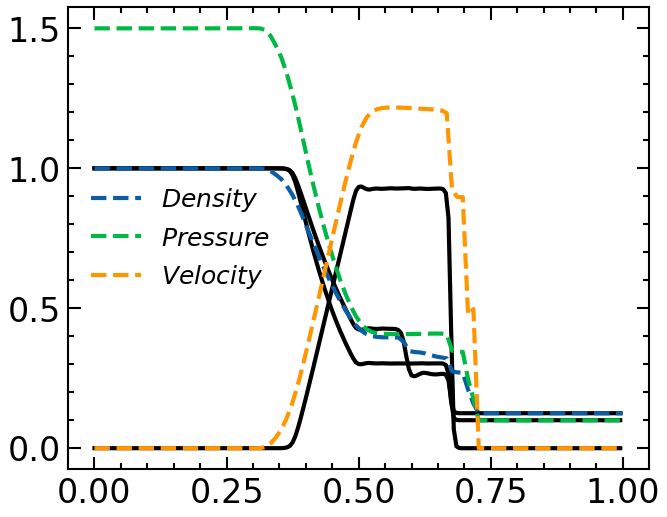

Step 2 Training Begin...
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[  0.5644, -37.6653],
        [  0.9167, -78.3996]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0047, -0.0019],
        [-0.0158,  0.9997]], device='cuda:0', dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[0.9699, 0.0291, 0.0016]], device='cuda:0', dtype=torch.float64),tensor([[ 9.5474e-01,  2.3351e-02, -7.3562e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[0.9426, 0.0436, 0.0026]], device='cuda:0', dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.115292


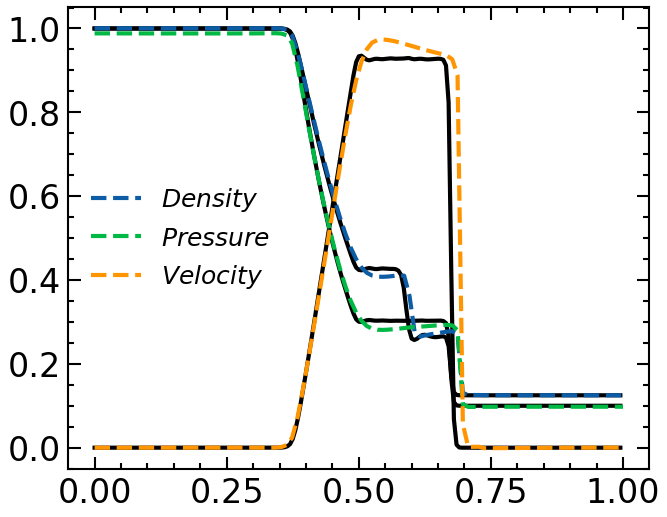

[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.0203,  8.3733],
        [-0.3001,  3.7296]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0065, -0.0138],
        [-0.0187,  1.0047]], device='cuda:0', dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9438e-01, 5.2415e-03, 3.8451e-05]], device='cuda:0',
       dtype=torch.float64),tensor([[ 9.8823e-01,  2.5725e-03, -4.8024e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[9.8731e-01, 6.5011e-03, 8.2046e-04]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.050980


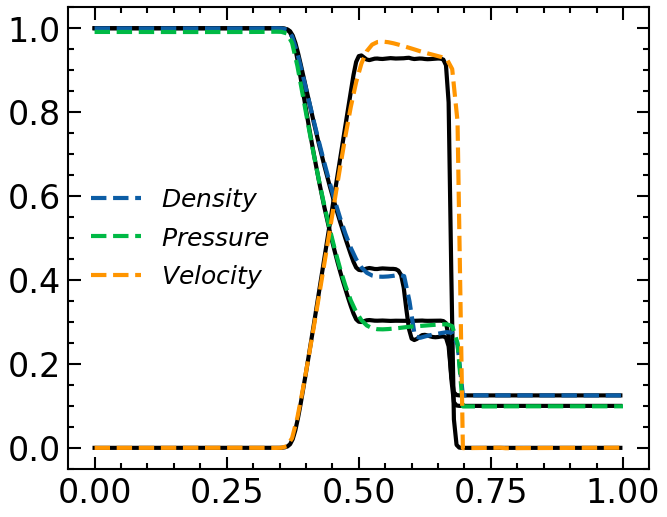

[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0055, -0.0187],
        [-0.0222,  1.0067]], device='cuda:0', dtype=torch.float64) and tensor([[0.9909, 0.0103, 0.0063]], device='cuda:0', dtype=torch.float64),tensor([[0.9856, 0.0042, 0.0018]], device='cuda:0', dtype=torch.float64),tensor([[0.9763, 0.0092, 0.0085]], device='cuda:0', dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.065996 (TGPT_PINN2 Step Criteria Met
)


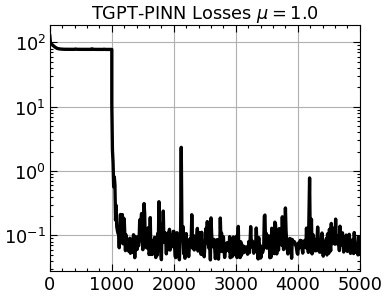

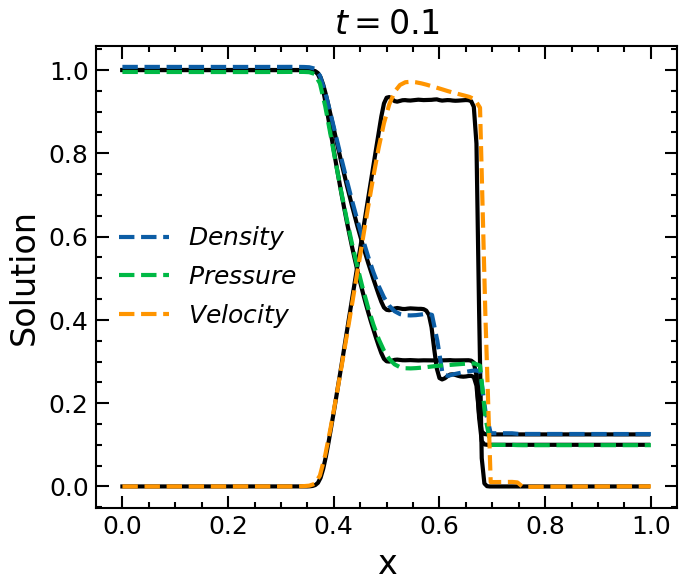

[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]: Loss: 125.679512
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.67951219512506
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 77.689680
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 77.449181
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9391e-01, 8.2611e-04],
        [4.9010e-03, 9.9880e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
Loss: 77.449181 (TGPT_PINN1 Step Criteria Met
)


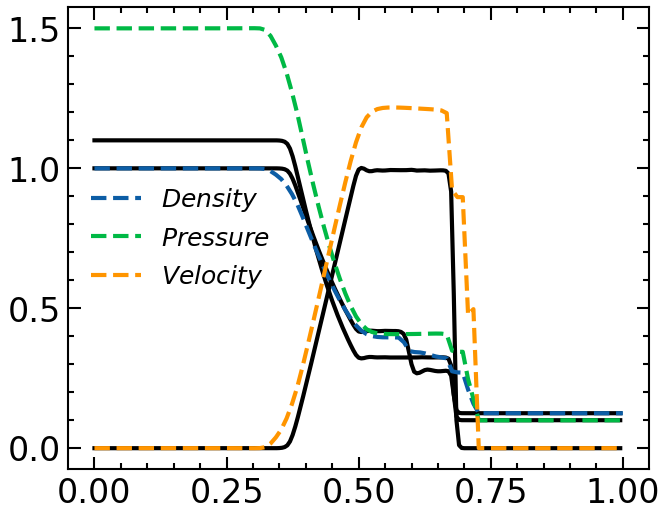

Step 2 Training Begin...
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.3134,  9.7685],
        [ 1.1307, 26.8785]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0361, -0.0029],
        [-0.0027,  0.9983]], device='cuda:0', dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0026,  0.0059, -0.0019]], device='cuda:0', dtype=torch.float64),tensor([[ 1.0893e+00,  1.0419e-03, -1.5996e-03]], device='cuda:0',
       dtype=torch.float64),tensor([[ 1.0244,  0.0182, -0.0012]], device='cuda:0', dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.074185


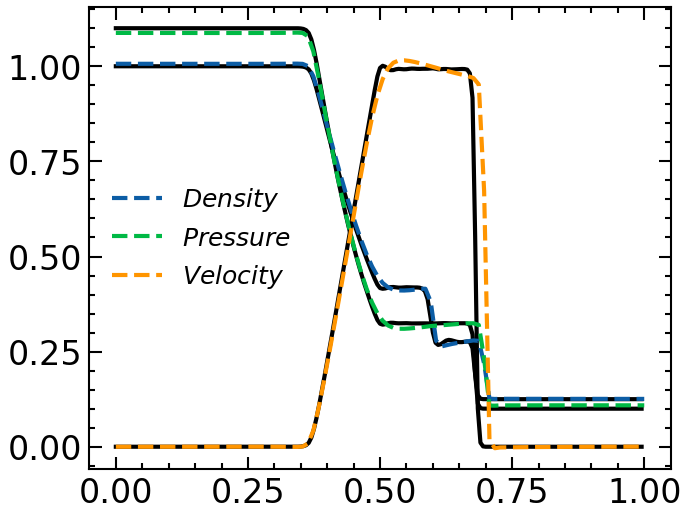

[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[-1.1694, 19.0595],
        [-0.3118, 76.9064]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0505, -0.0140],
        [-0.0191,  1.0014]], device='cuda:0', dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[0.9954, 0.0123, 0.0040]], device='cuda:0', dtype=torch.float64),tensor([[1.0720, 0.0175, 0.0070]], device='cuda:0', dtype=torch.float64),tensor([[0.9976, 0.0375, 0.0082]], device='cuda:0', dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.134591


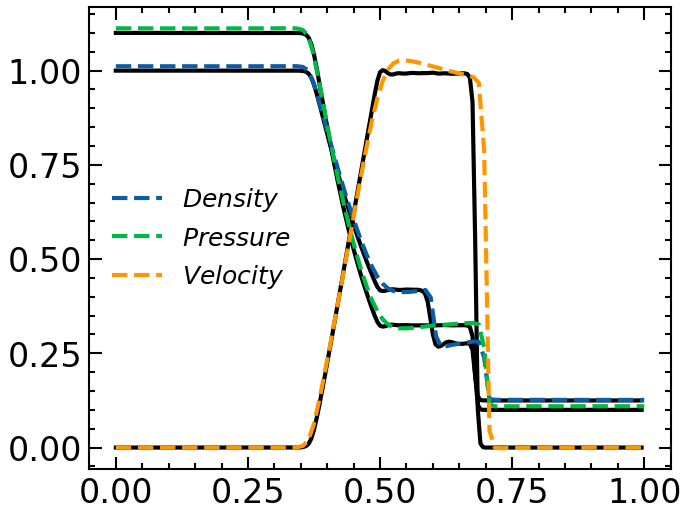

[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0521, -0.0169],
        [-0.0248,  1.0021]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.9595,  0.0426, -0.0048]], device='cuda:0', dtype=torch.float64),tensor([[ 1.0386,  0.0414, -0.0018]], device='cuda:0', dtype=torch.float64),tensor([[0.9719, 0.0507, 0.0065]], device='cuda:0', dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.048525 (TGPT_PINN2 Step Criteria Met
)


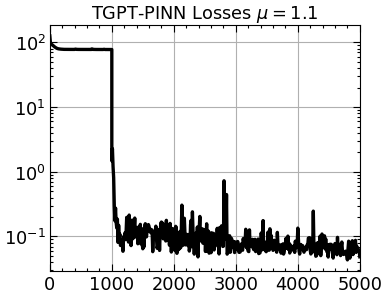

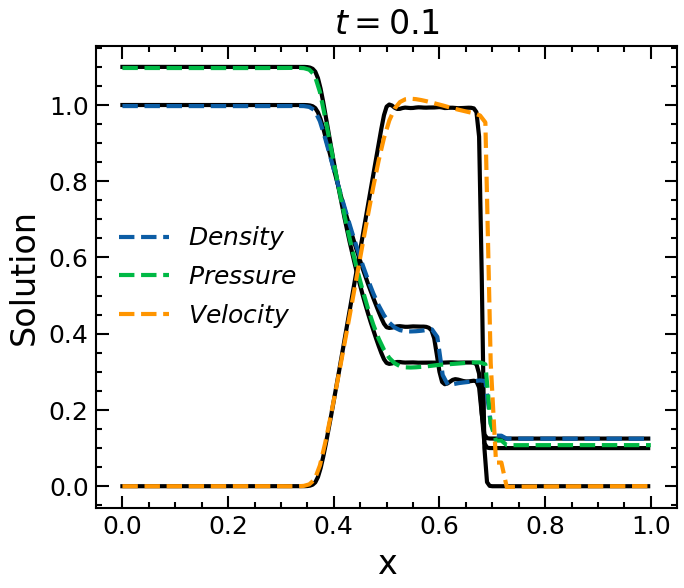

[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]: Loss: 125.644504
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.64450371787274
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 77.654687
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 77.414187
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9391e-01, 8.2611e-04],
        [4.9008e-03, 9.9880e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
Loss: 77.414187 (TGPT_PINN1 Step Criteria Met
)


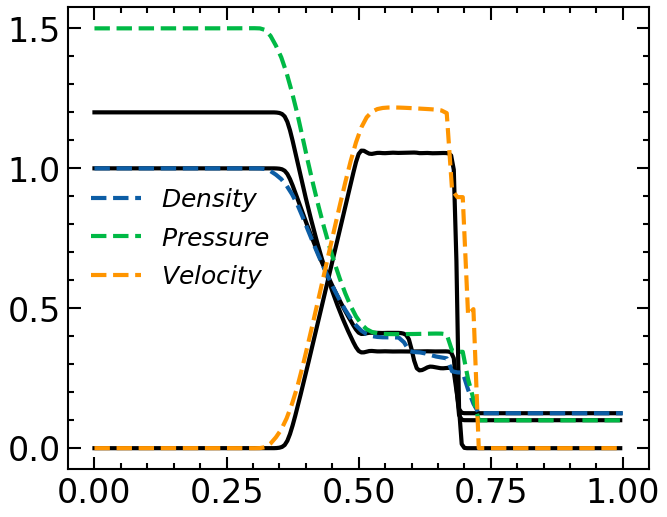

Step 2 Training Begin...
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[-2.6101,  7.1575],
        [-2.4482, 73.9514]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0525,  0.0024],
        [-0.0025,  0.9958]], device='cuda:0', dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[0.9193, 0.0914, 0.0049]], device='cuda:0', dtype=torch.float64),tensor([[1.0298, 0.0955, 0.0085]], device='cuda:0', dtype=torch.float64),tensor([[0.9292, 0.1207, 0.0107]], device='cuda:0', dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.212289


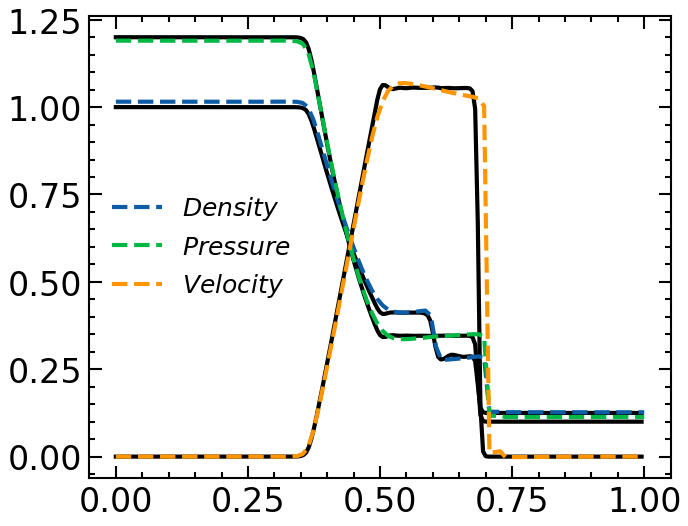

[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.7853,  8.2427],
        [-0.0585, -2.1274]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0784, -0.0102],
        [-0.0381,  0.9970]], device='cuda:0', dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[0.8132, 0.1711, 0.0053]], device='cuda:0', dtype=torch.float64),tensor([[0.9763, 0.1401, 0.0099]], device='cuda:0', dtype=torch.float64),tensor([[ 8.7430e-01,  1.8193e-01, -4.9508e-04]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.077386


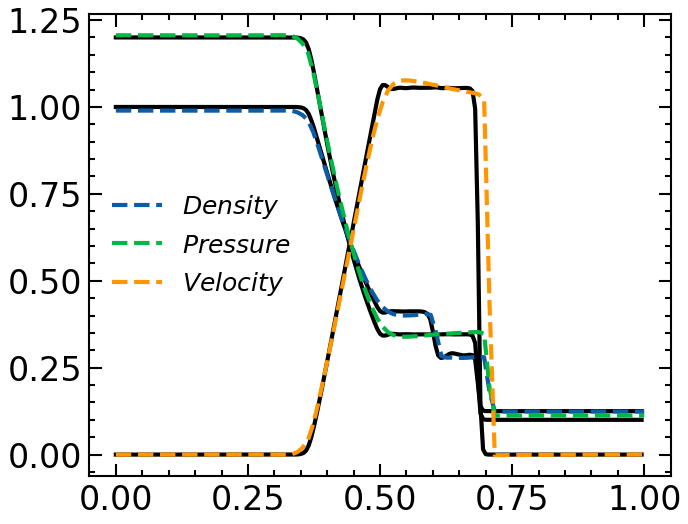

[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0796, -0.0112],
        [-0.0388,  0.9975]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.8000,  0.1992, -0.0067]], device='cuda:0', dtype=torch.float64),tensor([[ 0.9492,  0.1696, -0.0074]], device='cuda:0', dtype=torch.float64),tensor([[ 0.8378,  0.2115, -0.0019]], device='cuda:0', dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.096826 (TGPT_PINN2 Step Criteria Met
)


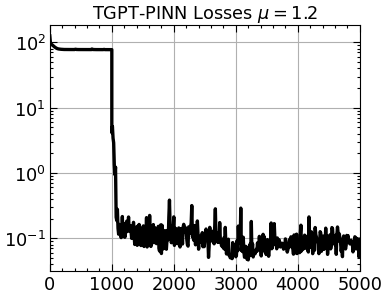

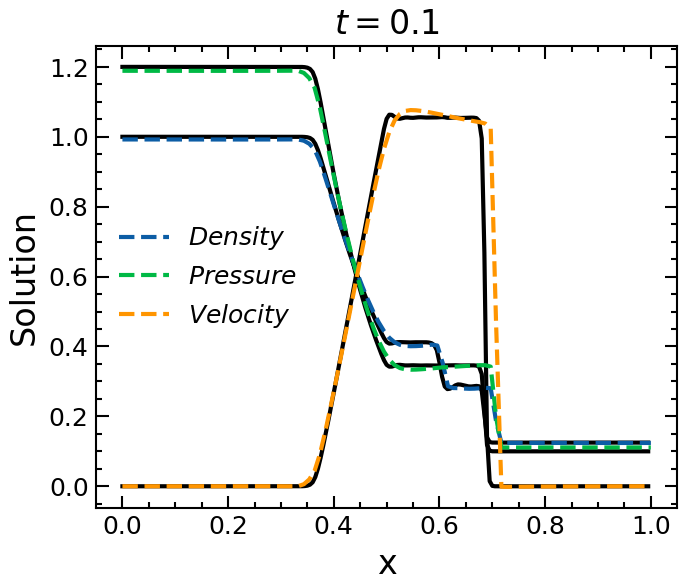

[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: Loss: 125.619495
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.61949524062042
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 77.629694
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 77.389201
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9391e-01, 8.2611e-04],
        [4.9007e-03, 9.9880e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
Loss: 77.389201 (TGPT_PINN1 Step Criteria Met
)


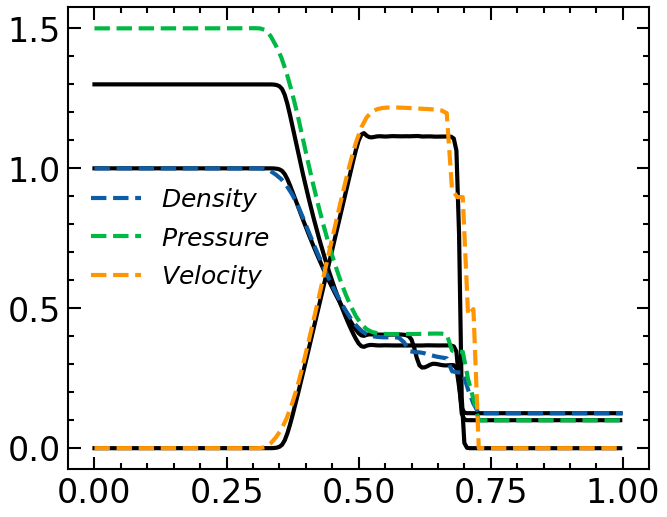

Step 2 Training Begin...
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.3812,  3.8304],
        [ 0.0346,  1.8083]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0625, -0.0049],
        [-0.0207,  0.9978]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.6741,  0.3320, -0.0049]], device='cuda:0', dtype=torch.float64),tensor([[0.8596, 0.2845, 0.0022]], device='cuda:0', dtype=torch.float64),tensor([[0.7037, 0.3351, 0.0058]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.078337


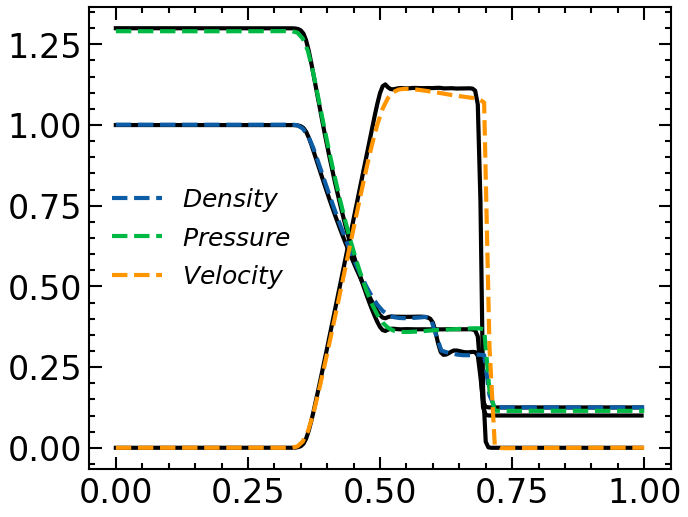

[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.1075, -1.5864],
        [-0.4172, -3.2865]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1153, -0.0186],
        [-0.0428,  0.9973]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[0.2847, 0.7122, 0.0040]], device='cuda:0', dtype=torch.float64),tensor([[ 0.3583,  0.6275, -0.0010]], device='cuda:0', dtype=torch.float64),tensor([[ 0.3225,  0.6704, -0.0020]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.032304


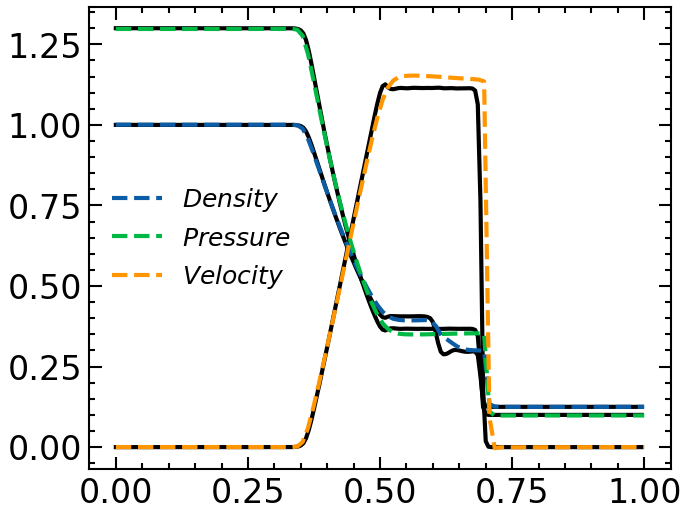

[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.1412, -0.0215],
        [-0.0613,  0.9975]], device='cuda:0', dtype=torch.float64) and tensor([[ 3.2481e-01,  6.7631e-01, -2.6558e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[ 4.1828e-01,  5.8251e-01, -3.3484e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[3.4763e-01, 6.4642e-01, 1.0924e-04]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.168855 (TGPT_PINN2 Step Criteria Met
)


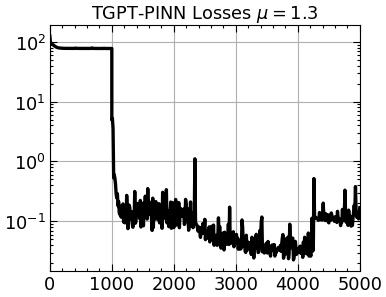

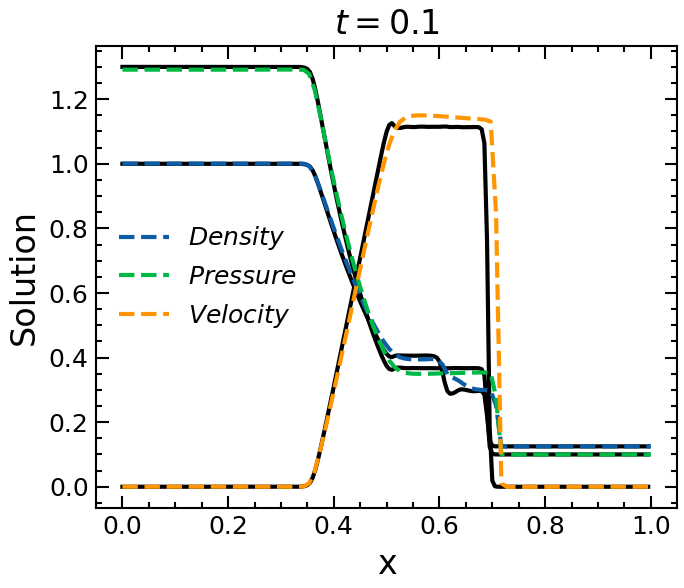

[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]: Loss: 125.604487
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.6044867633681
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 77.614701
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 77.374199
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9391e-01, 8.2610e-04],
        [4.9005e-03, 9.9880e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
Loss: 77.374199 (TGPT_PINN1 Step Criteria Met
)


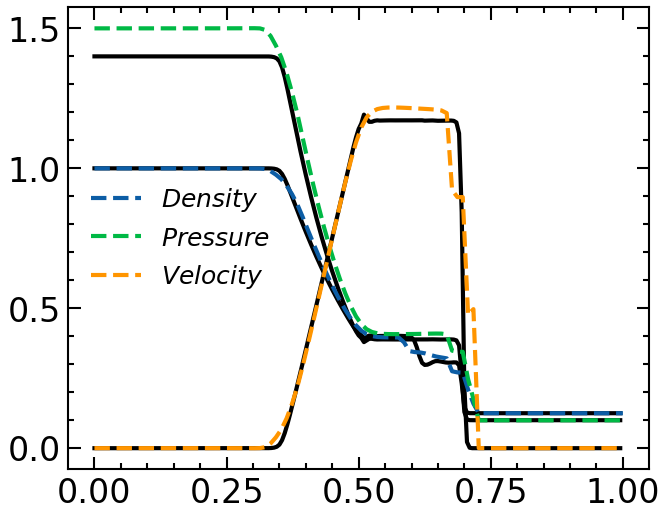

Step 2 Training Begin...
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[-1.1706,  1.1955],
        [-0.5715, 39.6544]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0901, -0.0064],
        [-0.0554,  0.9988]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[0.5368, 0.4416, 0.0244]], device='cuda:0', dtype=torch.float64),tensor([[0.7417, 0.3943, 0.0323]], device='cuda:0', dtype=torch.float64),tensor([[0.6131, 0.3828, 0.0597]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.087656


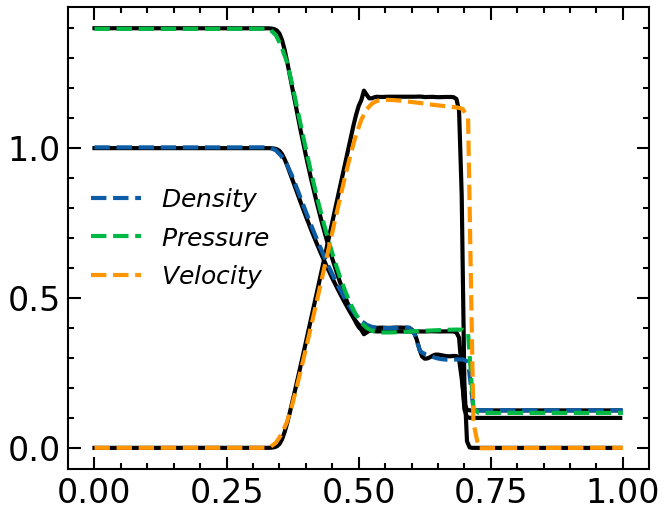

[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.2000,  0.4297],
        [-0.1330,  7.1824]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1142, -0.0199],
        [-0.0850,  0.9995]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[0.2147, 0.7750, 0.0034]], device='cuda:0', dtype=torch.float64),tensor([[0.2958, 0.7341, 0.0025]], device='cuda:0', dtype=torch.float64),tensor([[0.2399, 0.7716, 0.0028]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.051243


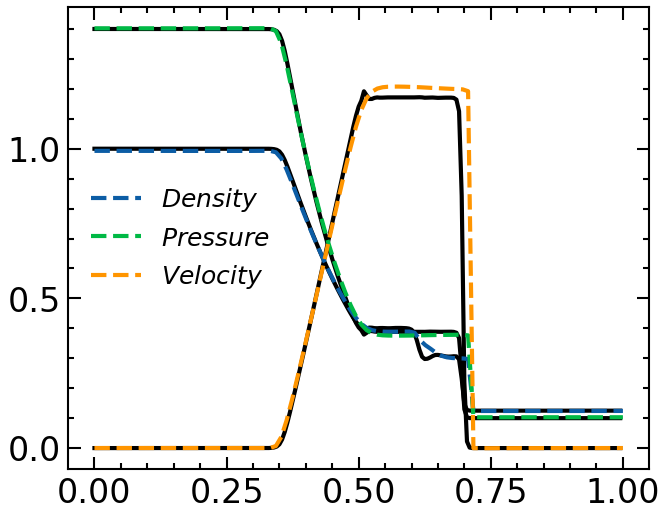

[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.1321, -0.0286],
        [-0.1004,  0.9999]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.1271,  0.8651, -0.0035]], device='cuda:0', dtype=torch.float64),tensor([[ 0.1618,  0.8294, -0.0031]], device='cuda:0', dtype=torch.float64),tensor([[ 0.1357,  0.8589, -0.0011]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.080435 (TGPT_PINN2 Step Criteria Met
)


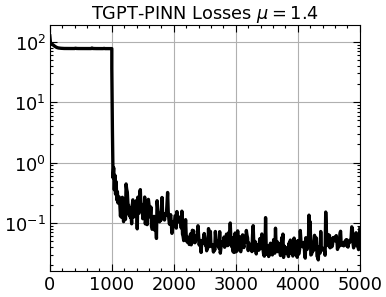

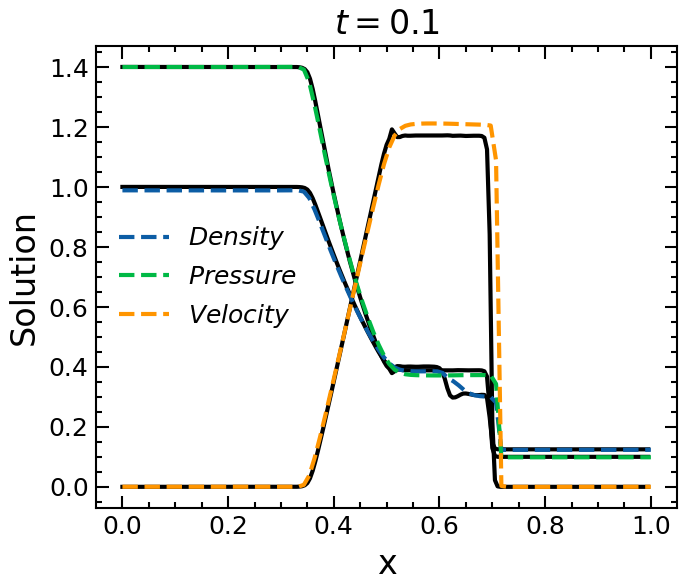

[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]: Loss: 125.599478
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.59947828611578
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 77.609708
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 77.369212
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9391e-01, 8.2610e-04],
        [4.9004e-03, 9.9880e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
Loss: 77.369212 (TGPT_PINN1 Step Criteria Met
)


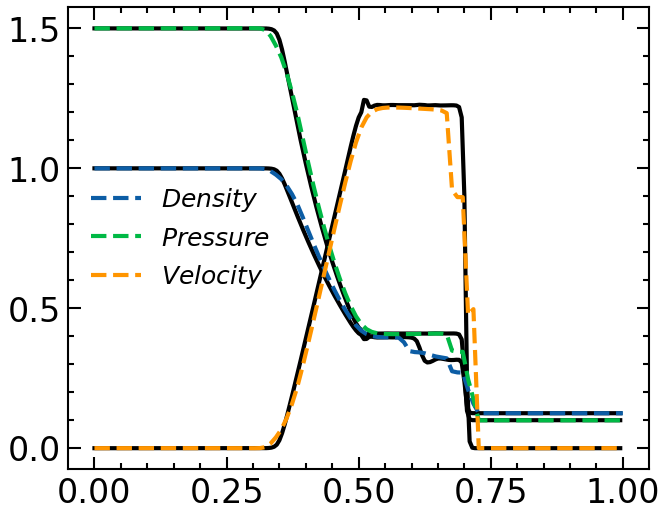

Step 2 Training Begin...
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[-2.7474,  9.2567],
        [-2.9132, 33.4735]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1090, -0.0041],
        [ 0.0136,  0.9942]], device='cuda:0', dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[0.6423, 0.3827, 0.0071]], device='cuda:0', dtype=torch.float64),tensor([[ 0.9960,  0.3199, -0.0047]], device='cuda:0', dtype=torch.float64),tensor([[ 0.7404,  0.3791, -0.0038]], device='cuda:0', dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.239748


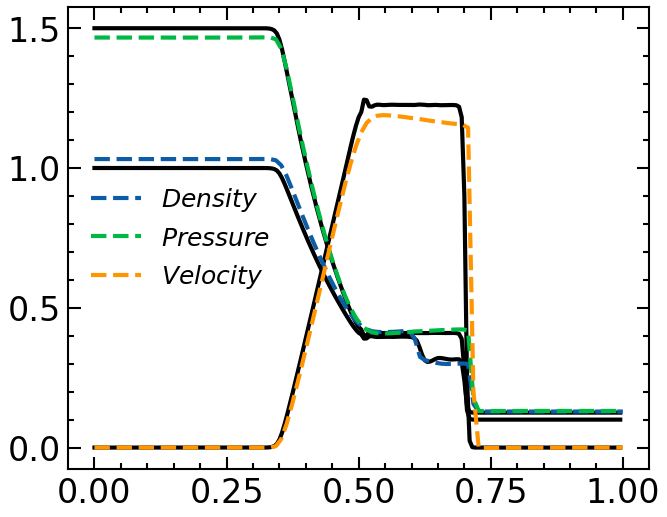

[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.1754,  4.6202],
        [-0.3145,  1.5818]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1851, -0.0188],
        [-0.0559,  0.9944]], device='cuda:0', dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.6166,  0.3783, -0.0030]], device='cuda:0', dtype=torch.float64),tensor([[ 0.8973,  0.3981, -0.0069]], device='cuda:0', dtype=torch.float64),tensor([[0.7001, 0.4178, 0.0051]], device='cuda:0', dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.068697


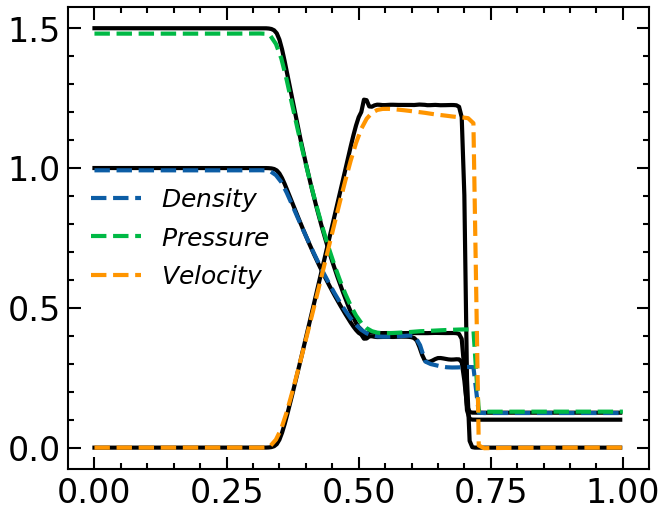

[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.2147, -0.0212],
        [-0.0581,  0.9943]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.3944,  0.5990, -0.0027]], device='cuda:0', dtype=torch.float64),tensor([[ 5.8002e-01,  6.1365e-01, -1.1405e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[4.8538e-01, 6.0273e-01, 5.4689e-05]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.049194 (TGPT_PINN2 Step Criteria Met
)


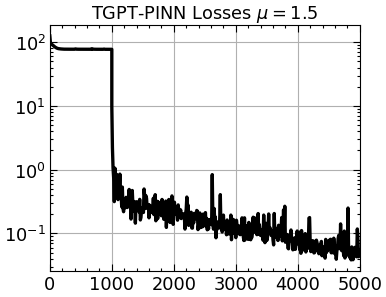

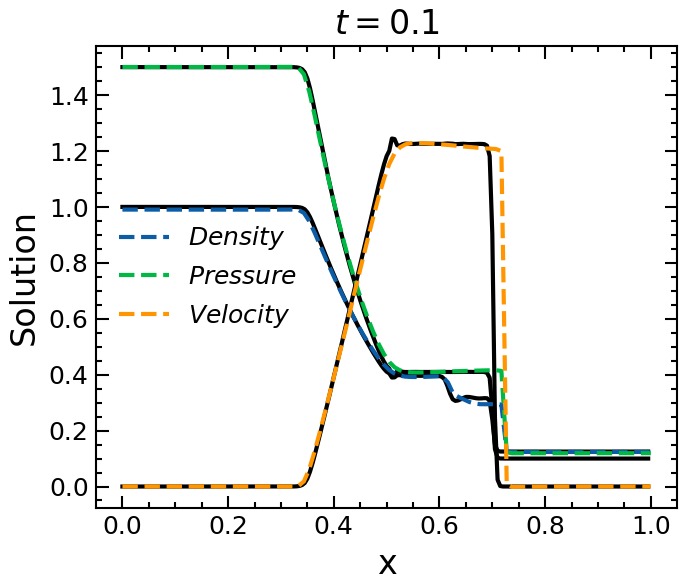

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: Loss: 125.604470
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.60446980886347
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 77.614715
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 77.374226
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9391e-01, 8.2610e-04],
        [4.9002e-03, 9.9880e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
Loss: 77.374226 (TGPT_PINN1 Step Criteria Met
)


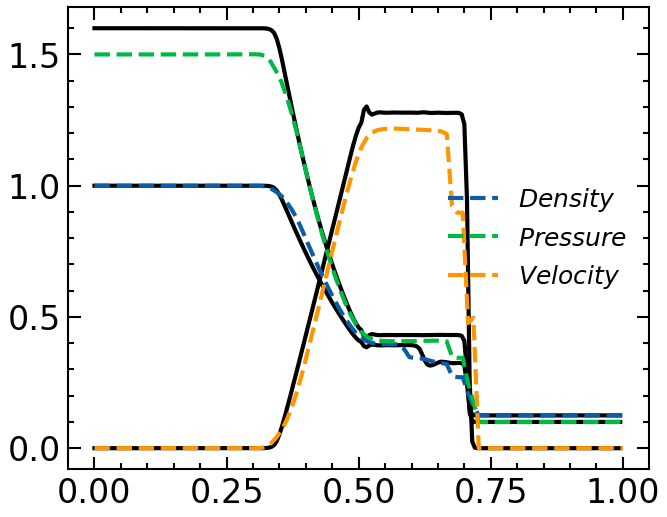

Step 2 Training Begin...
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[-2.0196, -1.6899],
        [-2.0765, 16.2667]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.2021, -0.0050],
        [-0.0083,  0.9915]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[0.8002, 0.1825, 0.0443]], device='cuda:0', dtype=torch.float64),tensor([[1.2399, 0.1685, 0.0400]], device='cuda:0', dtype=torch.float64),tensor([[0.9392, 0.1963, 0.0523]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.213485


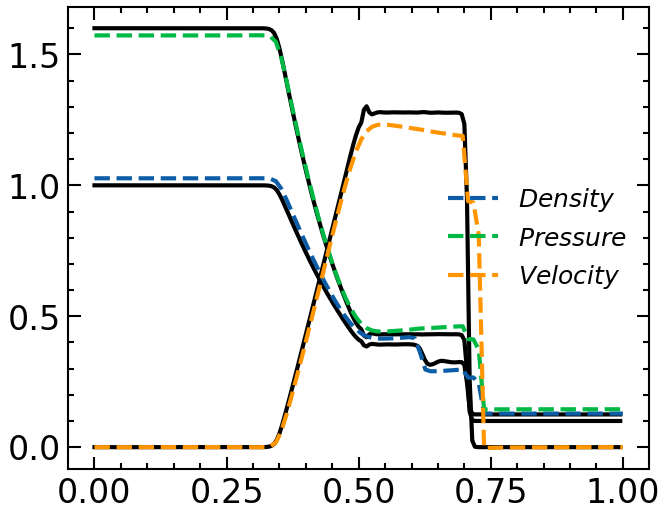

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.9349,  0.6563],
        [-0.6763, 16.3212]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.2239, -0.0165],
        [-0.0637,  0.9922]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[0.5252, 0.4617, 0.0154]], device='cuda:0', dtype=torch.float64),tensor([[0.8341, 0.4919, 0.0111]], device='cuda:0', dtype=torch.float64),tensor([[0.6619, 0.4873, 0.0044]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.078102


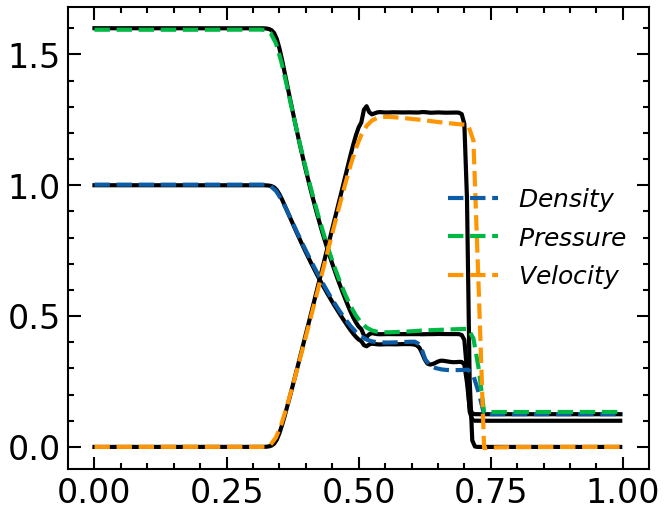

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.2554, -0.0271],
        [-0.0700,  0.9923]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.3893,  0.6236, -0.0097]], device='cuda:0', dtype=torch.float64),tensor([[ 0.5950,  0.6803, -0.0071]], device='cuda:0', dtype=torch.float64),tensor([[ 0.4879,  0.6364, -0.0054]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.031878 (TGPT_PINN2 Step Criteria Met
)


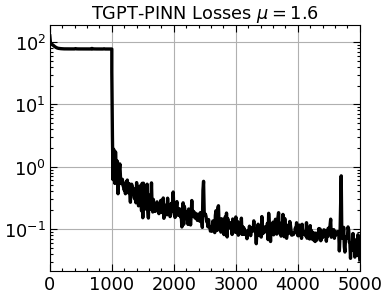

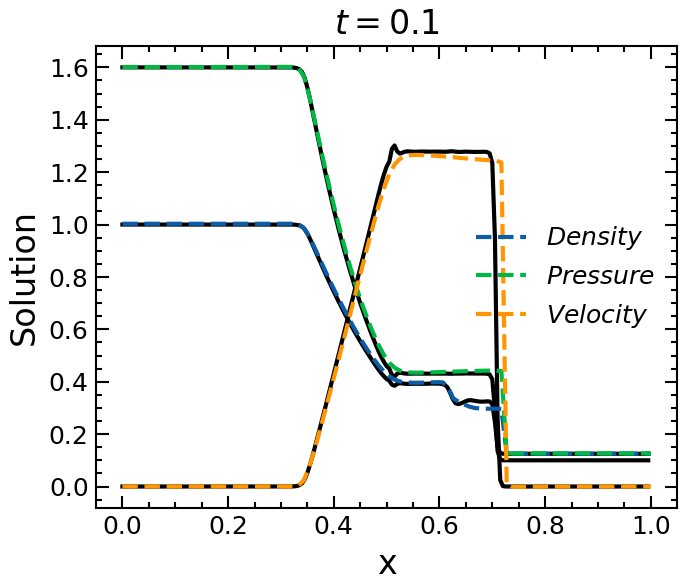

[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]: Loss: 125.619461
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.61946133161115
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 77.629722
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 77.389231
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9391e-01, 8.2610e-04],
        [4.9001e-03, 9.9880e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device=

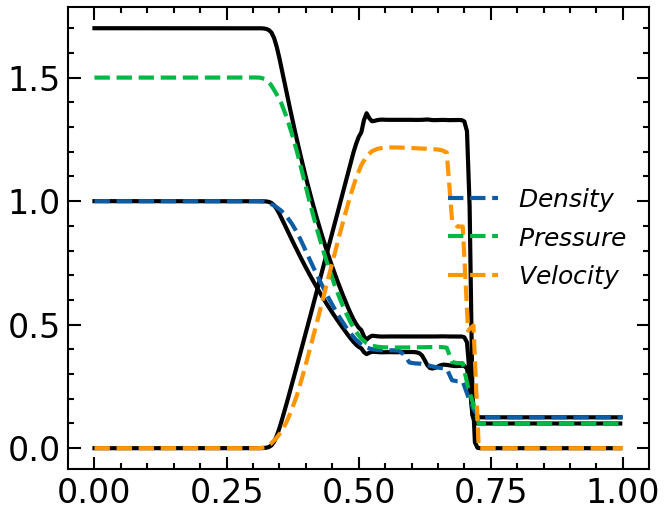

Step 2 Training Begin...
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.5260, 40.9788],
        [-1.9721, 12.2875]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1494, -0.0052],
        [-0.0110,  0.9965]], device='cuda:0', dtype=torch.float64)
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:tensor([[0.5038, 0.5297, 0.0054]], device='cuda:0', dtype=torch.float64),tensor([[0.8872, 0.5121, 0.0038]], device='cuda:0', dtype=torch.float64),tensor([[ 6.0215e-01,  5.4356e-01, -3.4020e-04]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.175551


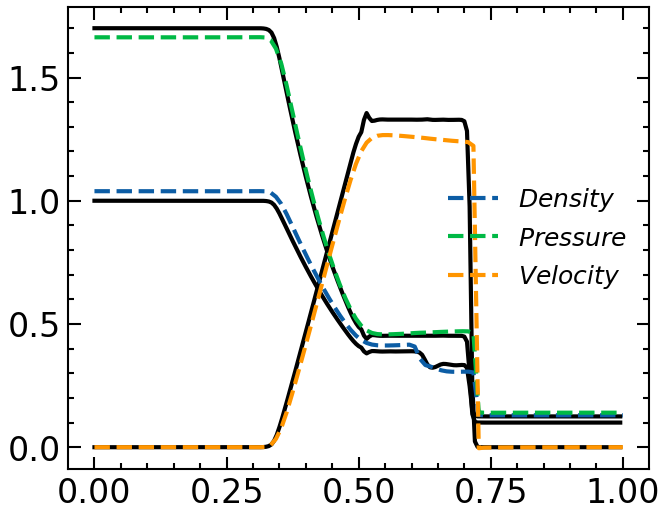

[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.7230, 32.0597],
        [-1.9964, 21.0273]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.2726, -0.0181],
        [-0.0663,  0.9952]], device='cuda:0', dtype=torch.float64)
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:tensor([[0.4288, 0.5522, 0.0167]], device='cuda:0', dtype=torch.float64),tensor([[0.7256, 0.6231, 0.0202]], device='cuda:0', dtype=torch.float64),tensor([[0.5372, 0.6160, 0.0024]], device='cuda:0', dtype=torch.float64)
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.110729


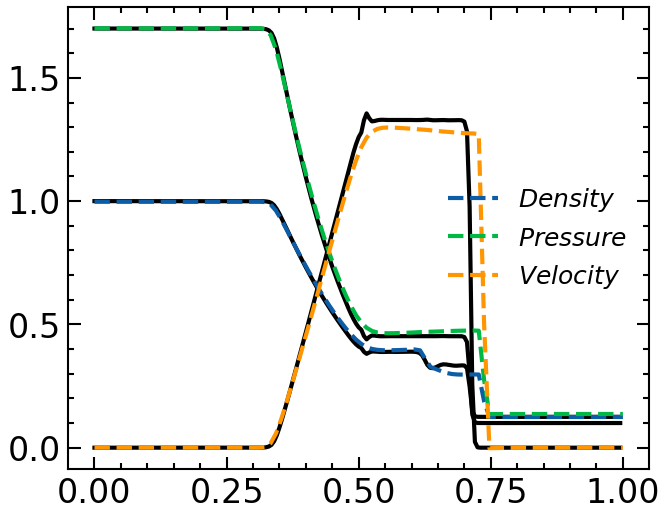

[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.2802, -0.0237],
        [-0.0696,  0.9956]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.3162,  0.6804, -0.0024]], device='cuda:0', dtype=torch.float64),tensor([[0.5211, 0.7771, 0.0048]], device='cuda:0', dtype=torch.float64),tensor([[0.4063, 0.7121, 0.0234]], device='cuda:0', dtype=torch.float64)
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.066553 (TGPT_PINN2 Step Criteria Met
)


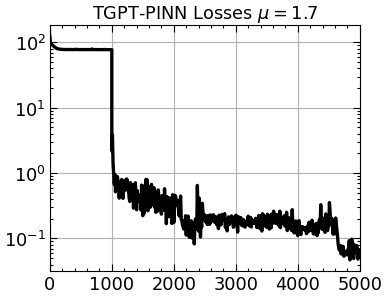

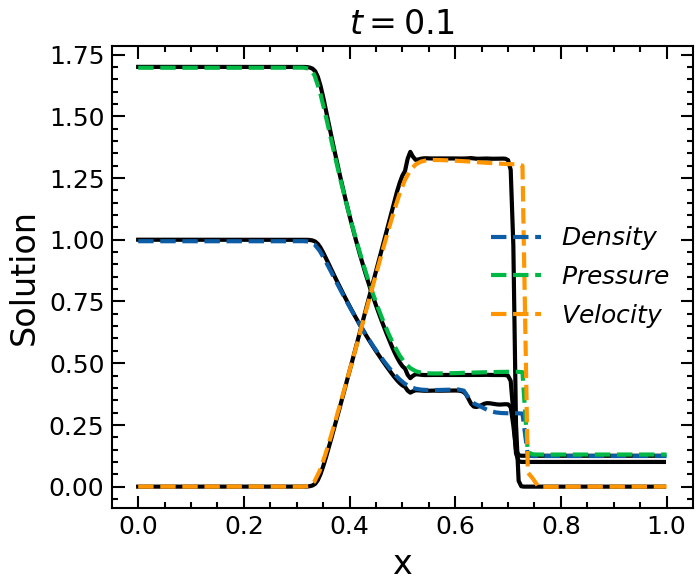

[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]: Loss: 125.644453
[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.64445285435883
[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 77.654729
[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 77.414242
[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9391e-01, 8.2610e-04],
        [4.8999e-03, 9.9880e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
Loss: 77.414242 (TGPT_PINN1 Step Criteria Met
)


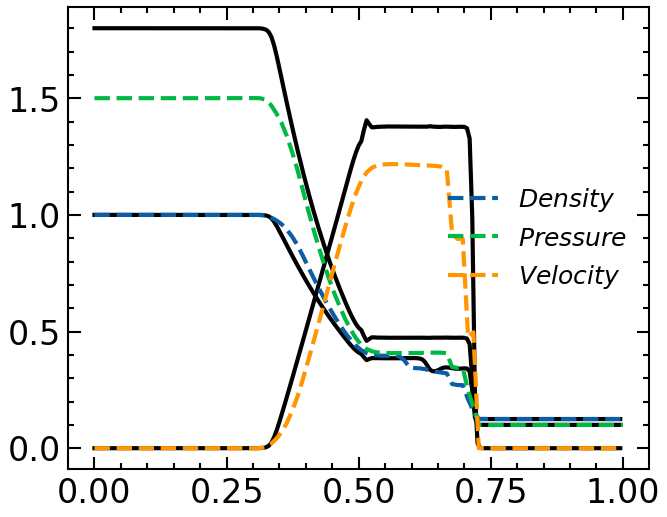

Step 2 Training Begin...
[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.7479,  8.3191],
        [ 0.3155,  8.5516]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1434, -0.0018],
        [ 0.0406,  0.9909]], device='cuda:0', dtype=torch.float64)
[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]:tensor([[0.5179, 0.5190, 0.0133]], device='cuda:0', dtype=torch.float64),tensor([[1.0116, 0.4916, 0.0093]], device='cuda:0', dtype=torch.float64),tensor([[ 6.6227e-01,  5.1319e-01, -6.4429e-04]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.268392


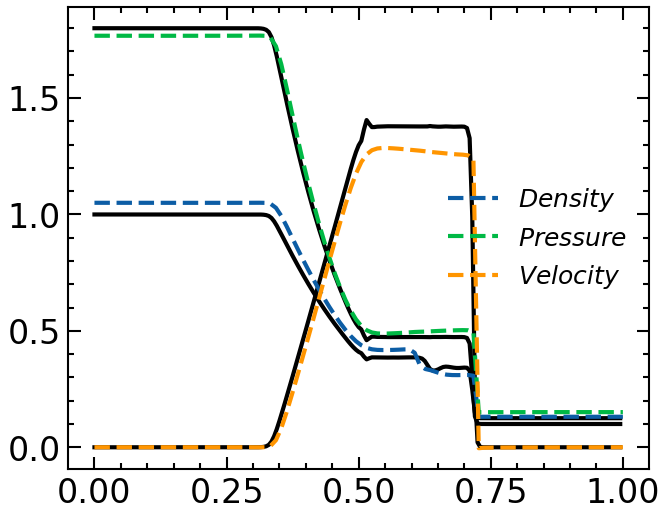

[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.2414,  1.4674],
        [-0.0840, -0.9789]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.3075, -0.0116],
        [-0.0498,  0.9883]], device='cuda:0', dtype=torch.float64)
[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]:tensor([[ 5.0674e-02,  9.4194e-01, -2.5418e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[ 0.0897,  1.1422, -0.0014]], device='cuda:0', dtype=torch.float64),tensor([[6.9147e-02, 1.0415e+00, 1.8388e-04]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.034156


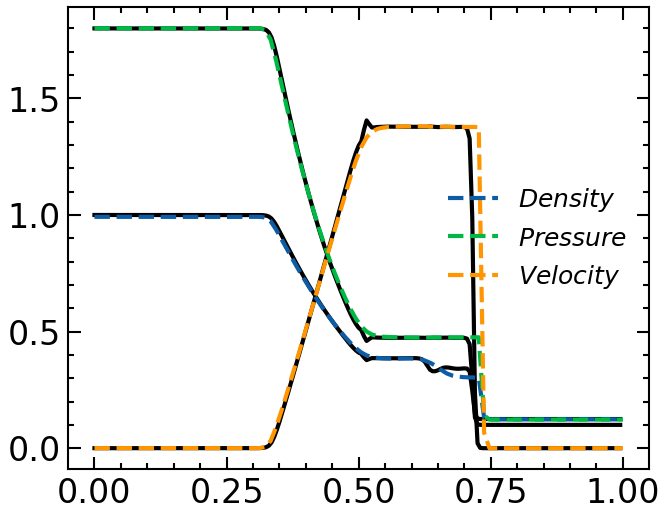

[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.3173, -0.0126],
        [-0.0605,  0.9870]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.0602,  0.9381, -0.0071]], device='cuda:0', dtype=torch.float64),tensor([[ 0.1015,  1.1365, -0.0057]], device='cuda:0', dtype=torch.float64),tensor([[0.0811, 1.0311, 0.0048]], device='cuda:0', dtype=torch.float64)
[1.0, 1.8, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.069003 (TGPT_PINN2 Step Criteria Met
)


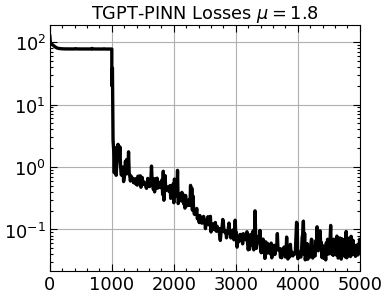

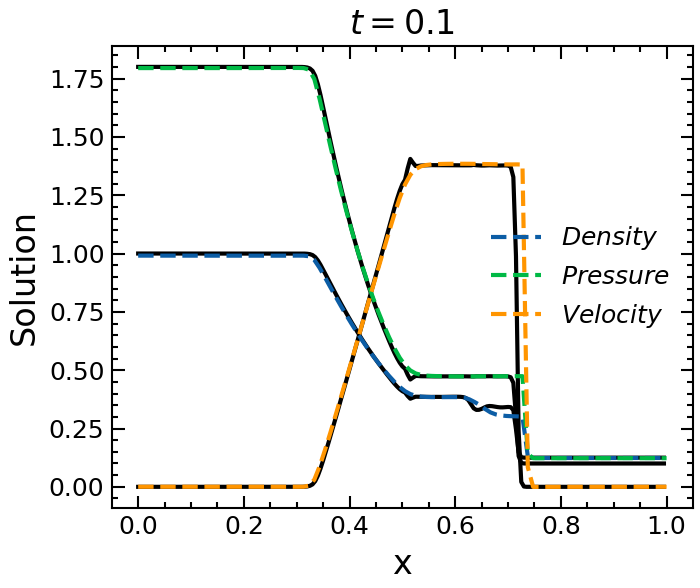

[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]: Loss: 125.679444
[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.6794443771065
[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 77.689736
[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 77.449250
[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9391e-01, 8.2610e-04],
        [4.8998e-03, 9.9880e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
Loss: 77.449250 (TGPT_PINN1 Step Criteria Met
)


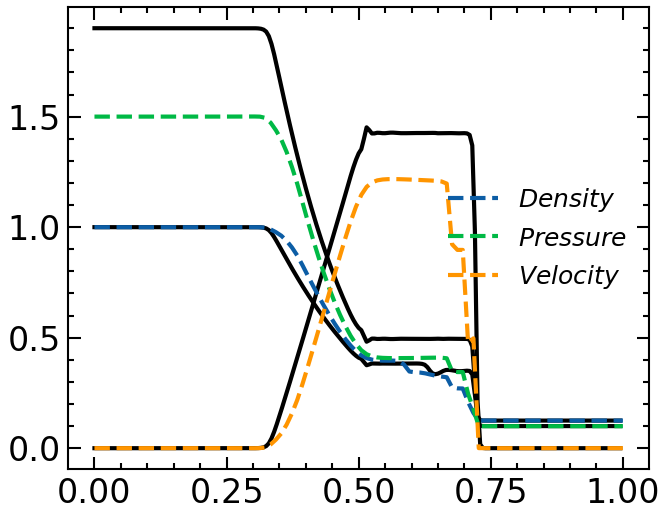

Step 2 Training Begin...
[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]:tensor([[ -2.9494, -64.9048],
        [ -2.9497, -75.4533]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1053, -0.0023],
        [ 0.0413,  0.9987]], device='cuda:0', dtype=torch.float64)
[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]:tensor([[0.1710, 0.9389, 0.0164]], device='cuda:0', dtype=torch.float64),tensor([[0.4276, 0.9250, 0.0016]], device='cuda:0', dtype=torch.float64),tensor([[0.2127, 0.8684, 0.0040]], device='cuda:0', dtype=torch.float64)
[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.743749


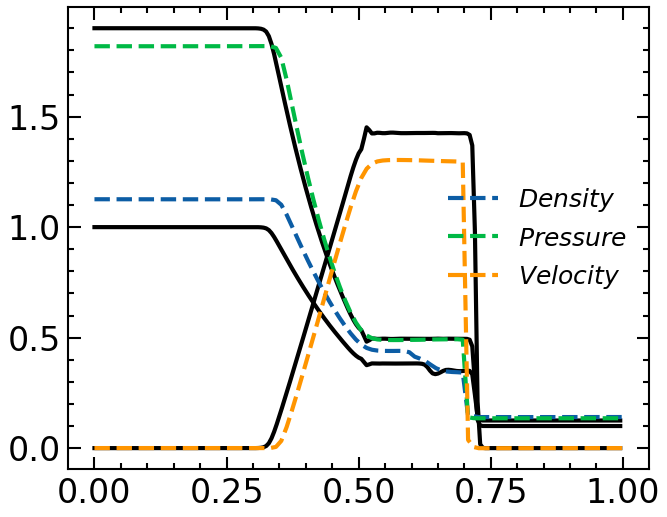

[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]:tensor([[-9.1937e-04,  2.1526e+00],
        [-1.9663e-02, -7.0276e+00]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.2238, -0.0038],
        [-0.0676,  0.9981]], device='cuda:0', dtype=torch.float64)
[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]:tensor([[0.0047, 1.0000, 0.0033]], device='cuda:0', dtype=torch.float64),tensor([[-0.0015,  1.2604,  0.0023]], device='cuda:0', dtype=torch.float64),tensor([[0.0140, 1.1083, 0.0012]], device='cuda:0', dtype=torch.float64)
[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.078920


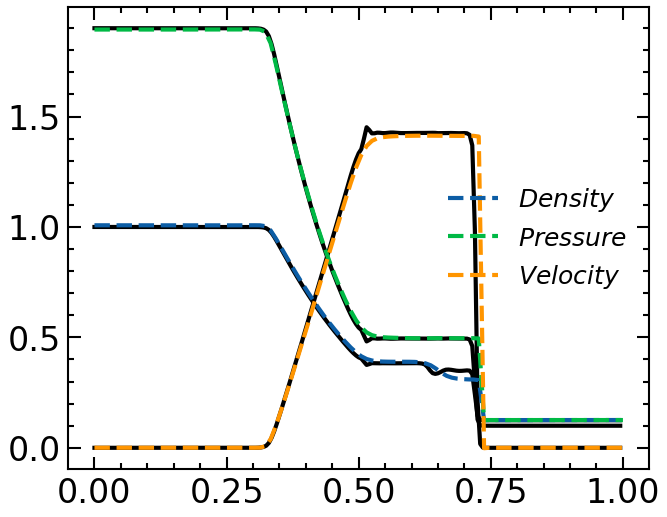

[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.2392, -0.0061],
        [-0.1329,  0.9987]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.0221,  0.9827, -0.0012]], device='cuda:0', dtype=torch.float64),tensor([[ 0.0668,  1.2261, -0.0053]], device='cuda:0', dtype=torch.float64),tensor([[0.0514, 1.0720, 0.0117]], device='cuda:0', dtype=torch.float64)
[1.0, 1.9, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.042347 (TGPT_PINN2 Step Criteria Met
)


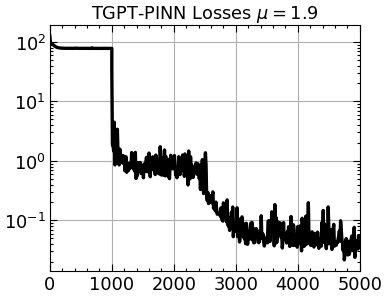

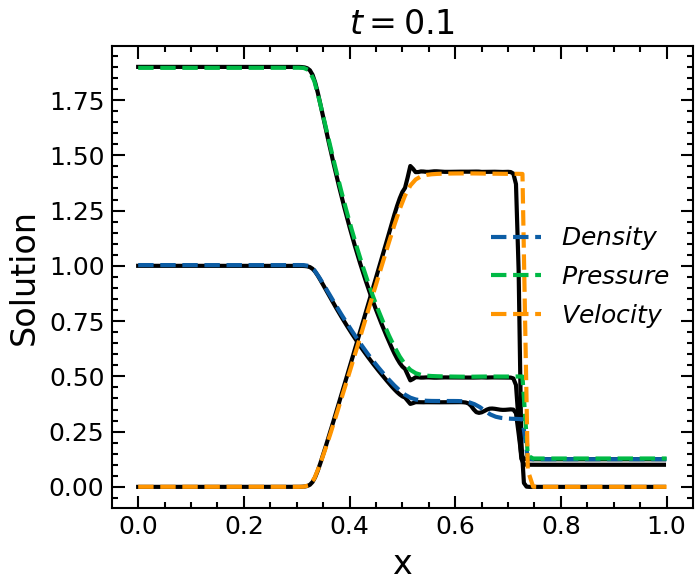

[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]: Loss: 125.724436
[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.72443589985419
[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 77.734743
[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 77.494253
[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]:tensor([[9.9391e-01, 8.2610e-04],
        [4.8996e-03, 9.9880e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
Loss: 77.494253 (TGPT_PINN1 Step Criteria Met
)


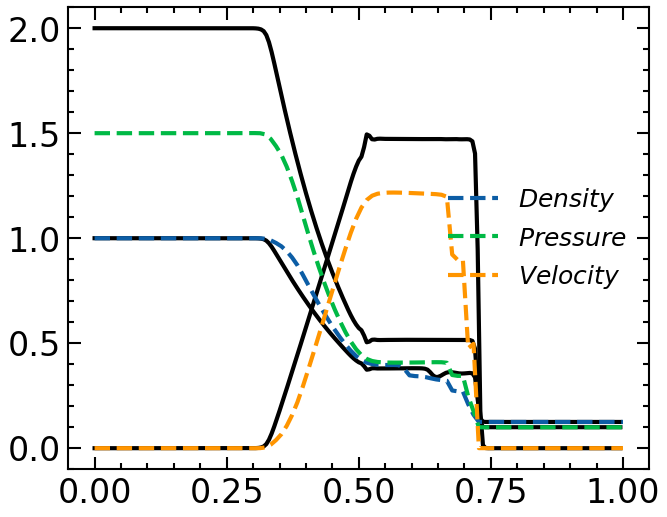

Step 2 Training Begin...
[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]:tensor([[ -5.7834, -56.8276],
        [  3.9903, -82.6619]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.2470, -0.0098],
        [ 0.0371,  0.9868]], device='cuda:0', dtype=torch.float64)
[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]:tensor([[0.9019, 0.1645, 0.0243]], device='cuda:0', dtype=torch.float64),tensor([[1.6869, 0.1573, 0.0153]], device='cuda:0', dtype=torch.float64),tensor([[1.0309, 0.1797, 0.0523]], device='cuda:0', dtype=torch.float64)
[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 1.019257


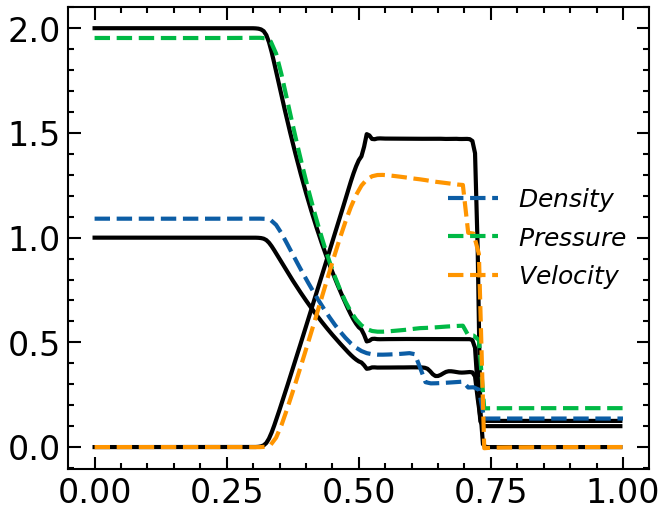

[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]:tensor([[ 2.8080, 35.9750],
        [-1.3256, -3.1805]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.3622, -0.0279],
        [-0.0446,  0.9858]], device='cuda:0', dtype=torch.float64)
[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]:tensor([[4.1640e-01, 5.9234e-01, 3.7232e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[ 0.8088,  0.7917, -0.0015]], device='cuda:0', dtype=torch.float64),tensor([[0.5808, 0.6700, 0.0082]], device='cuda:0', dtype=torch.float64)
[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.136388


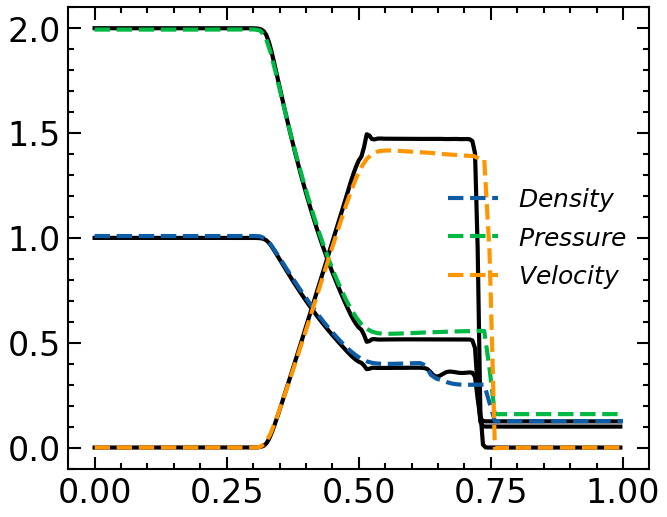

[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.3701, -0.0321],
        [-0.0548,  0.9850]], device='cuda:0', dtype=torch.float64) and tensor([[ 3.9335e-02,  9.5536e-01, -7.7911e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[ 0.0712,  1.2887, -0.0014]], device='cuda:0', dtype=torch.float64),tensor([[5.5635e-02, 1.1098e+00, 9.2489e-04]], device='cuda:0',
       dtype=torch.float64)
[1.0, 2.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.063204 (TGPT_PINN2 Step Criteria Met
)


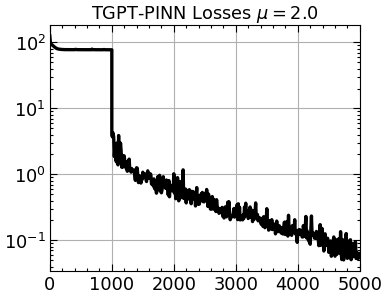

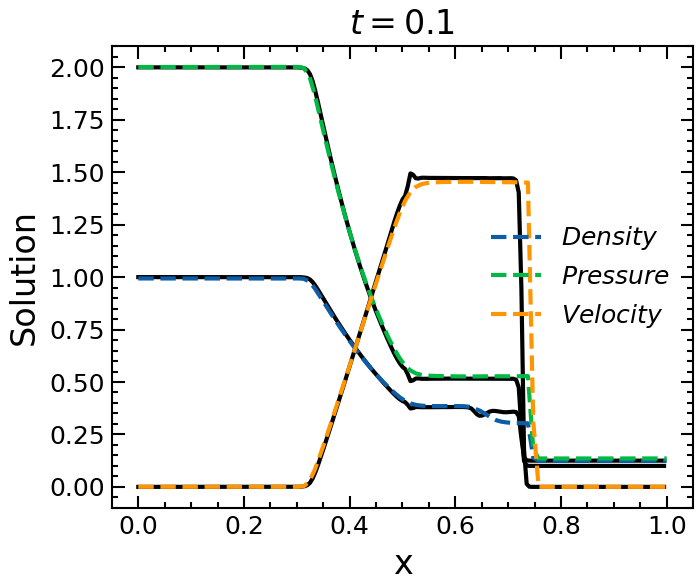

In [5]:
i=2
layers_gpt = np.array([2, i+1, 3])
c_initial  = torch.full((1,i+1), 1/(i+1))

for nu in nu_training:
    ini[1] = nu
    IC_data = create_IC_data(ini,Xi, Xf, Ti, Tf, IC_pts)
    IC_xt     = IC_data[0].to(device)
    IC_u      = IC_data[1]

    BC_data = create_BC_data(ini,Xi, Xf, Ti, Tf, IC_pts)
    BC_xt     = BC_data[0].to(device)
    BC_u      = BC_data[1]

    xt_en = Move_Time_1D(IC_xt, Tf).to(device)
    weno_u = Euler_WENO(Xi,Xf,Ti,Tf,ini,gamma,delta_t=0.0001,delta_x=0.005)
    VGPT_PINN = GPT(ini, layers_gpt, P_list[0:i+1], c_initial, Nc, Tc, gamma,Tf).to(device).double()
    
    tgpt_losses = gpt_train(VGPT_PINN, ini, xt_resid,  IC_xt, IC_u,BC_xt, BC_u, f_hat,xt_test,xt_en, xt_RH, xt_RHL,weno_u,  epochs_tgpt, lr_tgpt, tol_tgpt)

    loss_plot(tgpt_losses[1], tgpt_losses[2], dpi=80, figsize=(5,4),title=fr"VGPT-PINN Losses $\mu={round(ini[1],3)}$")
    
    Nx_test=N_test
    Nt_test=T_test
    plt.figure(dpi=150, figsize=(5,4))
    
    ind = 100
    plt.plot(weno_u[3],weno_u[0],'k')#,label="$Density$"
    plt.plot(weno_u[3],weno_u[1],'k')#,label="$Pressure$"
    plt.plot(weno_u[3],weno_u[2],'k')#,label="$velocity$"
    
    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,0:1][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Density$")
    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,1:2][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Pressure$")
    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,2:][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Velocity$")
    
    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),VGPT_PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),VGPT_PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),VGPT_PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
    plt.xlabel("x",     fontsize=16)
    plt.ylabel("Solution", fontsize=16)
    plt.title(fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    
    plt.legend(fontsize = 12)#
    plt.show()

[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]: Loss: 125.724521
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.72452067237732
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 36.045521
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 23.858787
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0044e+00, -1.7637e-04],
        [-6.7970e-03,  1.0020e+00]], device='cuda:0', dtype=torch.float64) and tensor([[0.4004, 0.2671, 0.2506]], device='cuda:0', dtype=torch.float64),tensor([[0.3999, 0.2589, 0.2542]], device='cuda:0', dtype=torch.float64),tensor([[0.2572, 0.2641, 0.3992]], device='cuda:0', dtype=torch.float64)
Loss: 23.858787 (TGPT_PINN1 Step Criteria Met
)


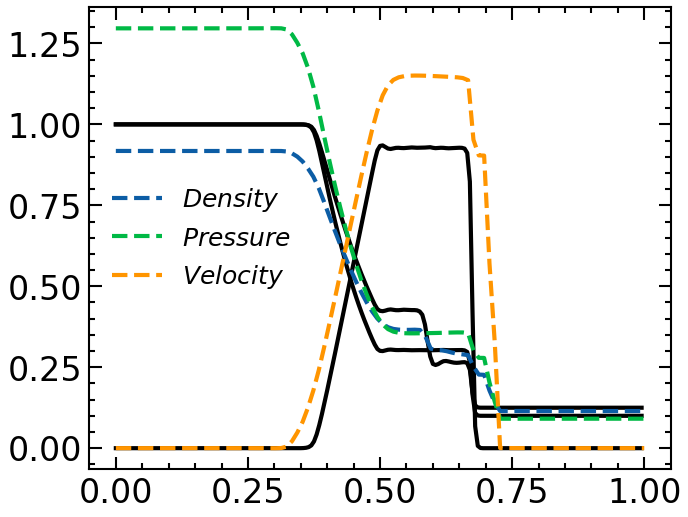

Step 2 Training Begin...
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[0.2704, 7.8317],
        [0.2524, 7.4032]], device='cuda:0', dtype=torch.float64) and tensor([[ 9.8037e-01,  9.7028e-04],
        [-2.3922e-02,  1.0015e+00]], device='cuda:0', dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.8021,  0.1919, -0.0014]], device='cuda:0', dtype=torch.float64),tensor([[0.7968, 0.1364, 0.0016]], device='cuda:0', dtype=torch.float64),tensor([[0.7638, 0.1755, 0.0130]], device='cuda:0', dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.055171


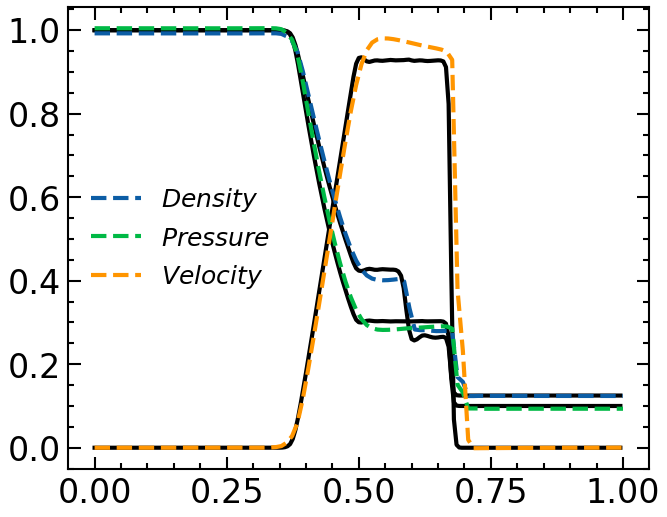

[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[-1.8661e-03, -2.6459e+00],
        [ 5.5590e-02,  2.5731e+00]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.9999,  0.0024],
        [-0.0026,  1.0022]], device='cuda:0', dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.9926,  0.0135, -0.0035]], device='cuda:0', dtype=torch.float64),tensor([[0.9865, 0.0015, 0.0018]], device='cuda:0', dtype=torch.float64),tensor([[0.9553, 0.0365, 0.0029]], device='cuda:0', dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.061696


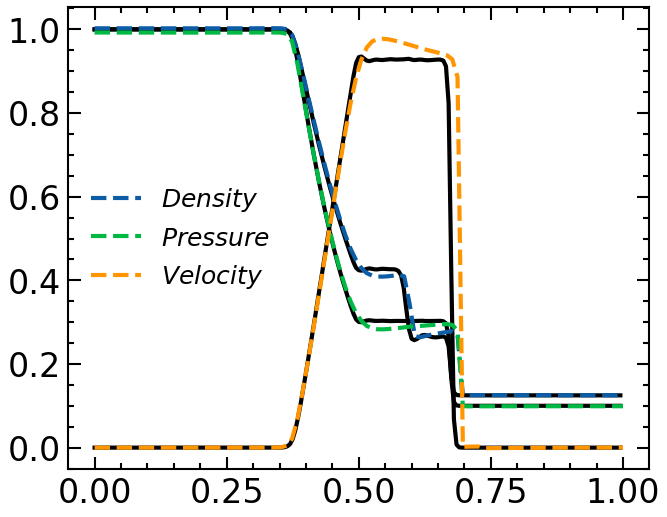

[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0002,  0.0016],
        [-0.0028,  1.0023]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0136, -0.0098, -0.0013]], device='cuda:0', dtype=torch.float64),tensor([[9.9406e-01, 6.8942e-04, 7.2306e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[9.8210e-01, 1.6306e-02, 1.9971e-04]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.0, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.076069 (TGPT_PINN2 Step Criteria Met
)


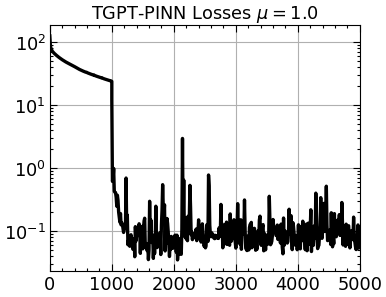

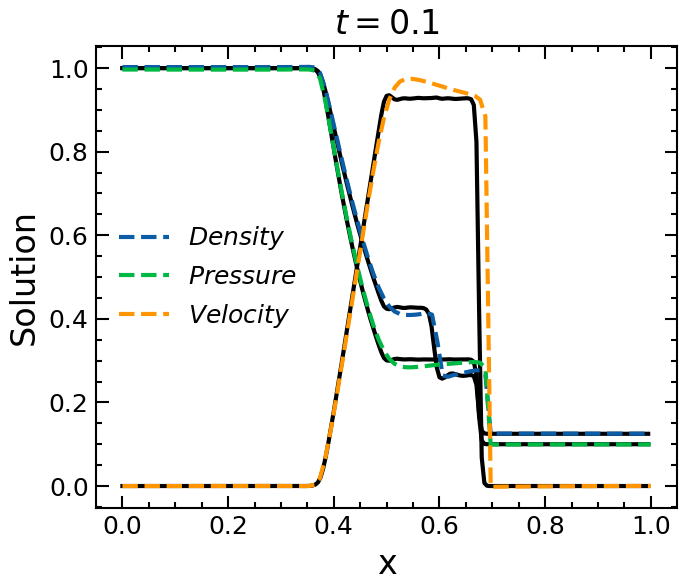

[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]: Loss: 125.679512
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.679512195125
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 36.012426
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 24.084980
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0044e+00, -1.7673e-04],
        [-6.8014e-03,  1.0020e+00]], device='cuda:0', dtype=torch.float64) and tensor([[0.4005, 0.2671, 0.2506]], device='cuda:0', dtype=torch.float64),tensor([[0.4001, 0.2589, 0.2542]], device='cuda:0', dtype=torch.float64),tensor([[0.2572, 0.2641, 0.3992]], device='cuda:0', dtype=torch.float64)
Loss: 24.084980 (TGPT_PINN1 Step Criteria Met
)


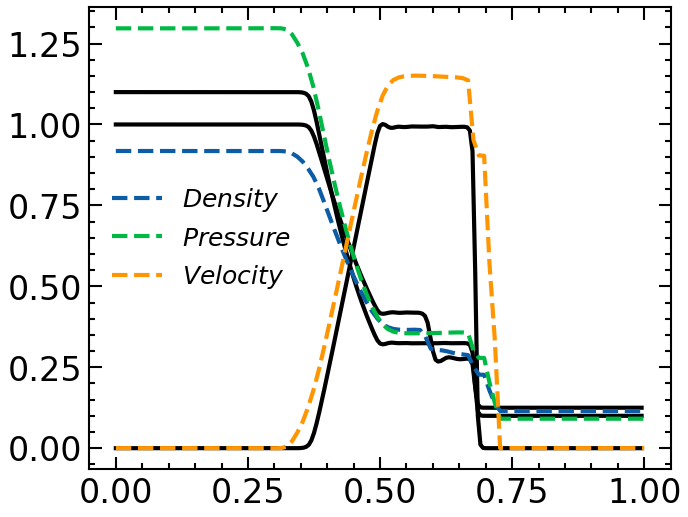

Step 2 Training Begin...
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[-3.2723e-01, -1.3809e+01],
        [-1.7760e-03, -1.0075e+01]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.9973, -0.0018],
        [-0.0280,  1.0000]], device='cuda:0', dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[0.7538, 0.2260, 0.0213]], device='cuda:0', dtype=torch.float64),tensor([[0.8268, 0.1493, 0.0196]], device='cuda:0', dtype=torch.float64),tensor([[0.7442, 0.1989, 0.0401]], device='cuda:0', dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.102744


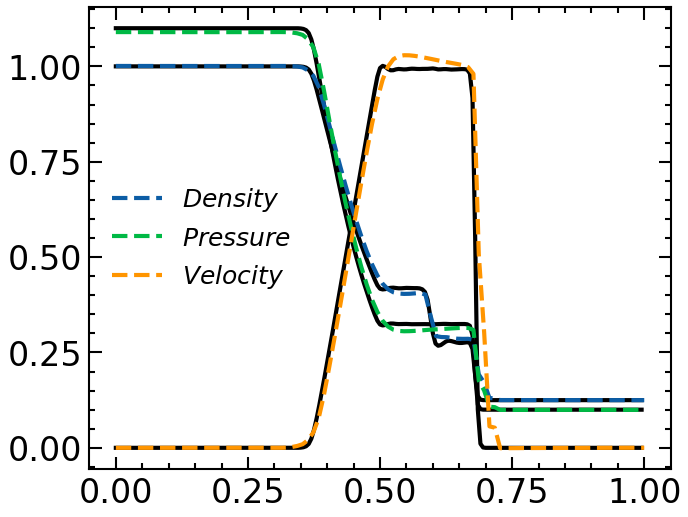

[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[ 15.0119, 233.7535],
        [ -7.0061, -83.7918]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.9956, -0.0157],
        [-0.0129,  1.0054]], device='cuda:0', dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[0.9282, 0.0910, 0.0082]], device='cuda:0', dtype=torch.float64),tensor([[1.0081, 0.0260, 0.0036]], device='cuda:0', dtype=torch.float64),tensor([[0.9625, 0.0120, 0.0441]], device='cuda:0', dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.830981


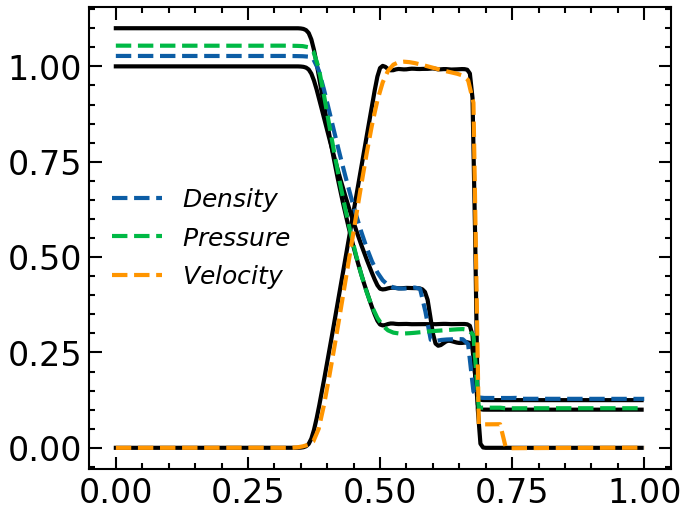

[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0089, -0.0216],
        [-0.0102,  1.0064]], device='cuda:0', dtype=torch.float64) and tensor([[ 9.2095e-01,  9.5681e-02, -8.9009e-05]], device='cuda:0',
       dtype=torch.float64),tensor([[1.0345, 0.0204, 0.0025]], device='cuda:0', dtype=torch.float64),tensor([[ 9.7766e-01, -4.3882e-04,  3.7683e-02]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.1, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.099649 (TGPT_PINN2 Step Criteria Met
)


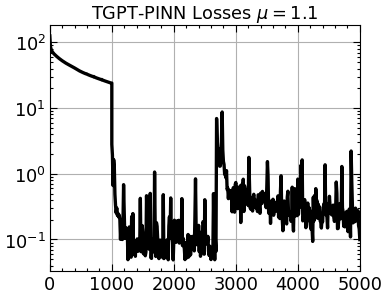

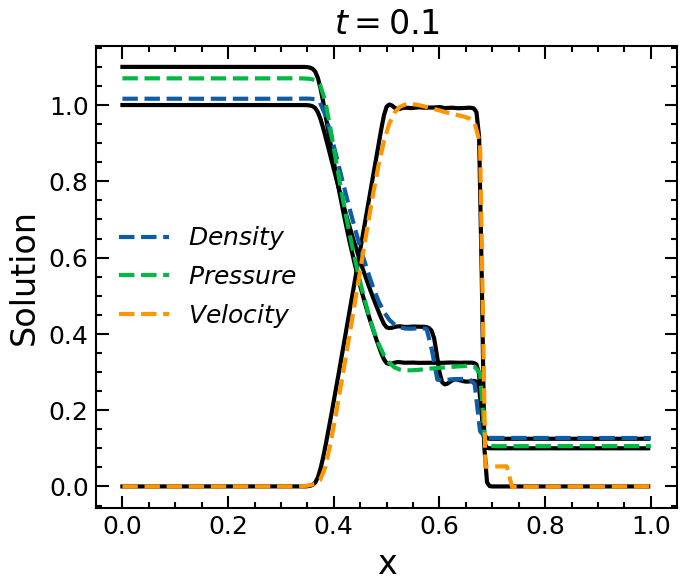

[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]: Loss: 125.644504
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.64450371787268
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 35.989321
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 23.822551
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0044e+00, -1.7698e-04],
        [-6.8056e-03,  1.0020e+00]], device='cuda:0', dtype=torch.float64) and tensor([[0.4006, 0.2671, 0.2506]], device='cuda:0', dtype=torch.float64),tensor([[0.4003, 0.2590, 0.2542]], device='cuda:0', dtype=torch.float64),tensor([[0.2572, 0.2641, 0.3992]], device='cuda:0', dtype=torch.float64)
Loss: 23.822551 (TGPT_PINN1 Step Criteria Met
)


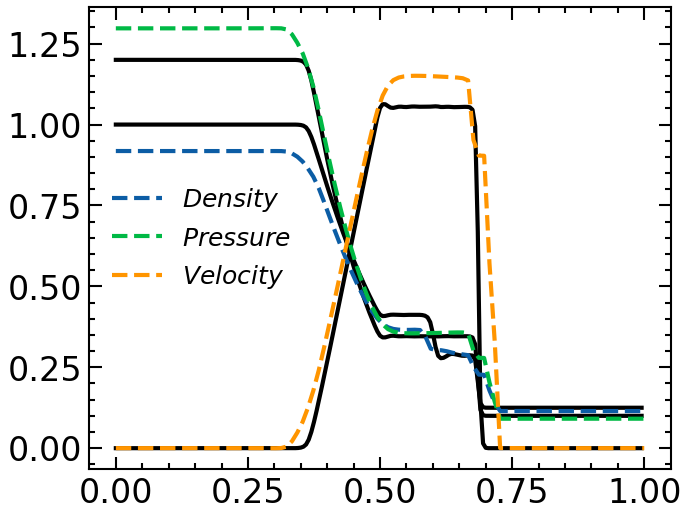

Step 2 Training Begin...
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[ -0.0984,   2.4799],
        [ -0.9765, -10.9034]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0213e+00,  2.0921e-04],
        [-2.7127e-02,  9.9964e-01]], device='cuda:0', dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[0.6499, 0.3469, 0.0223]], device='cuda:0', dtype=torch.float64),tensor([[0.7937, 0.2167, 0.0153]], device='cuda:0', dtype=torch.float64),tensor([[0.6757, 0.3115, 0.0314]], device='cuda:0', dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.200006


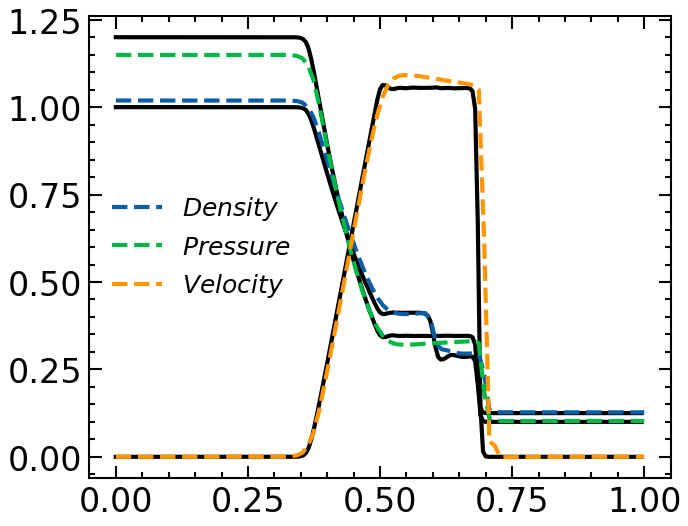

[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.1343, -1.9553],
        [-0.1477, -3.8311]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0373, -0.0048],
        [-0.0339,  0.9987]], device='cuda:0', dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[0.6295, 0.3727, 0.0035]], device='cuda:0', dtype=torch.float64),tensor([[0.7342, 0.2957, 0.0040]], device='cuda:0', dtype=torch.float64),tensor([[0.6406, 0.3523, 0.0092]], device='cuda:0', dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.049856


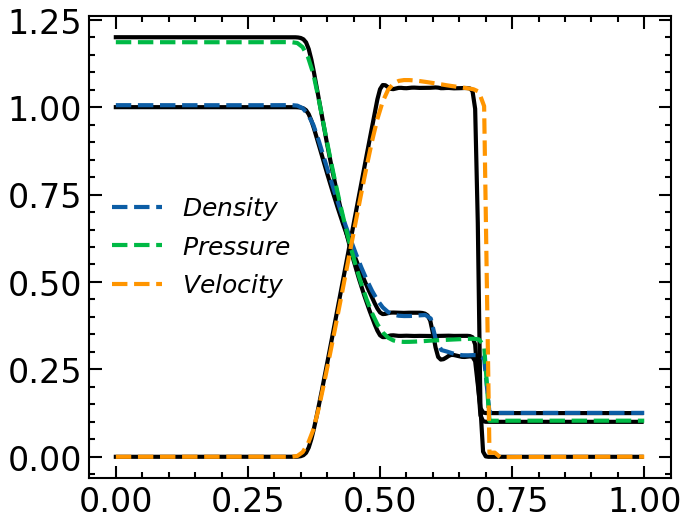

[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0420, -0.0075],
        [-0.0413,  0.9991]], device='cuda:0', dtype=torch.float64) and tensor([[0.6480, 0.3530, 0.0018]], device='cuda:0', dtype=torch.float64),tensor([[0.7359, 0.3020, 0.0036]], device='cuda:0', dtype=torch.float64),tensor([[0.6503, 0.3212, 0.0337]], device='cuda:0', dtype=torch.float64)
[1.0, 1.2, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.084036 (TGPT_PINN2 Step Criteria Met
)


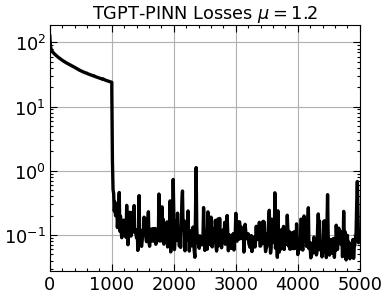

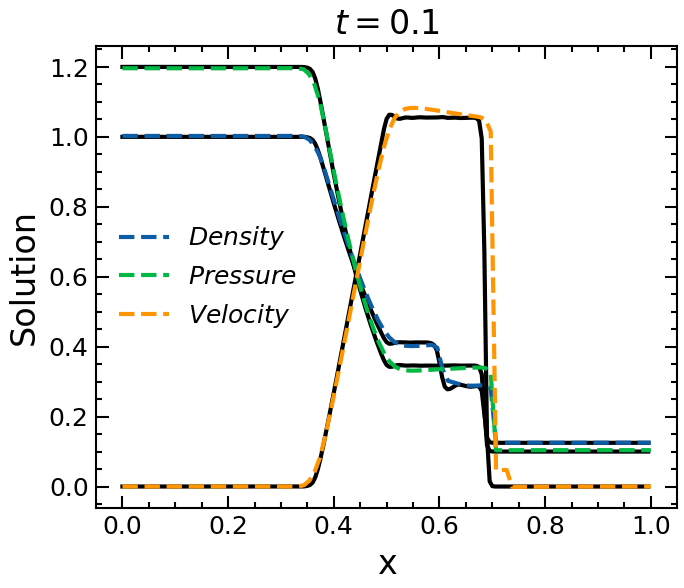

[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: Loss: 125.619495
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.61949524062037
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 35.976205
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 23.838153
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0044e+00, -1.7719e-04],
        [-6.8099e-03,  1.0020e+00]], device='cuda:0', dtype=torch.float64) and tensor([[0.4007, 0.2672, 0.2506]], device='cuda:0', dtype=torch.float64),tensor([[0.4006, 0.2591, 0.2542]], device='cuda:0', dtype=torch.float64),tensor([[0.2572, 0.2641, 0.3992]], device='cuda:0', dtype=torch.float64)
Loss: 23.838153 (TGPT_PINN1 Step Criteria Met
)


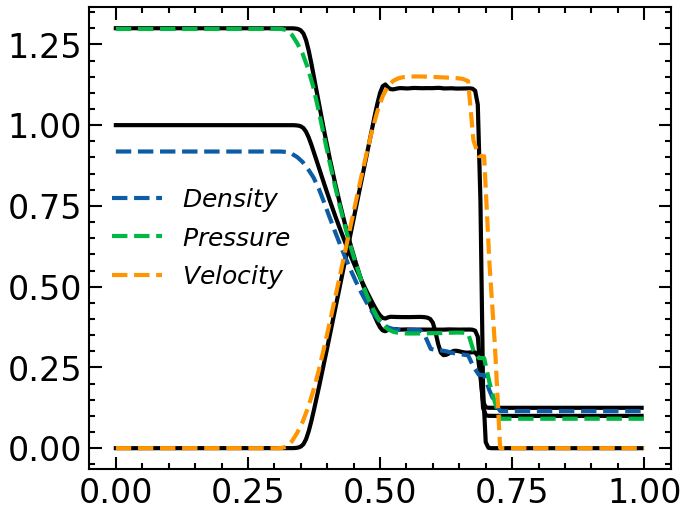

Step 2 Training Begin...
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[ -0.0311,  -3.4293],
        [ -0.7832, -17.7525]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0438e+00, -1.5337e-04],
        [ 8.1270e-03,  9.9592e-01]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[1.0256, 0.0173, 0.0026]], device='cuda:0', dtype=torch.float64),tensor([[ 1.2274e+00,  2.2119e-02, -1.8697e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[0.9885, 0.0773, 0.0131]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.227909


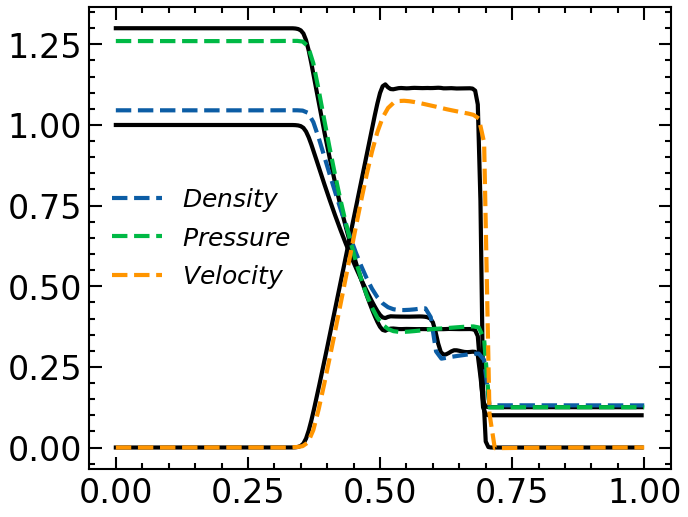

[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[0.3700, 6.5531],
        [0.2362, 6.3185]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1070, -0.0136],
        [-0.0053,  0.9930]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[0.9517, 0.0460, 0.0035]], device='cuda:0', dtype=torch.float64),tensor([[0.7345, 0.3765, 0.0009]], device='cuda:0', dtype=torch.float64),tensor([[ 0.6161,  0.4095, -0.0025]], device='cuda:0', dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.068107


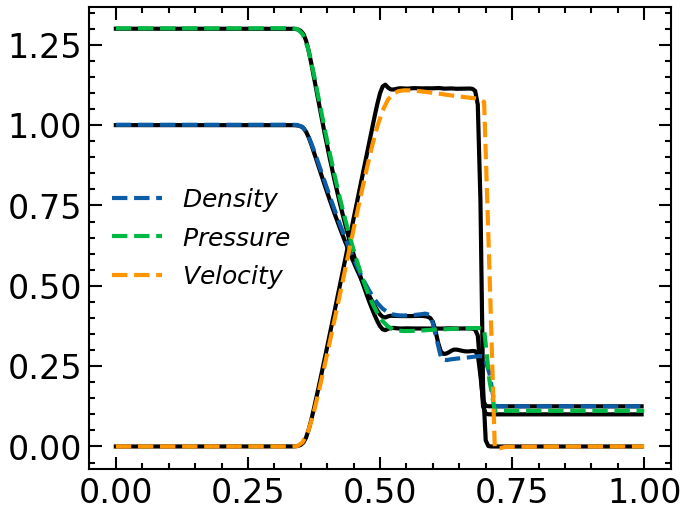

[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.1190, -0.0209],
        [-0.0183,  0.9928]], device='cuda:0', dtype=torch.float64) and tensor([[0.9660, 0.0403, 0.0044]], device='cuda:0', dtype=torch.float64),tensor([[ 6.5349e-01,  4.2607e-01, -2.7067e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[ 5.5715e-01,  4.6128e-01, -3.5160e-04]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.3, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.070436 (TGPT_PINN2 Step Criteria Met
)


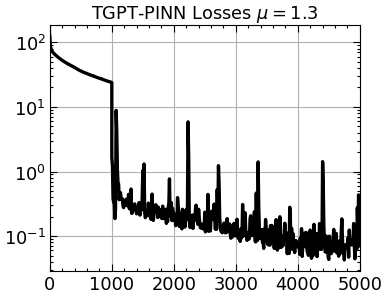

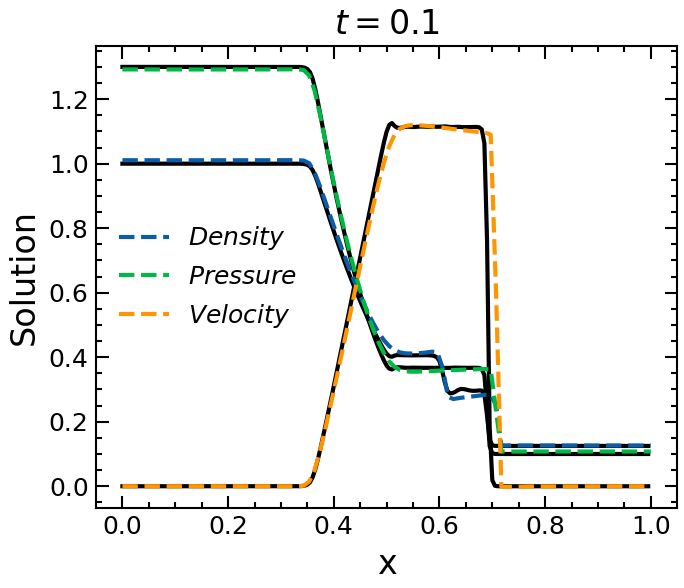

[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]: Loss: 125.604487
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.60448676336804
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 35.973080
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 23.833734
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0044e+00, -1.7755e-04],
        [-6.8143e-03,  1.0020e+00]], device='cuda:0', dtype=torch.float64) and tensor([[0.4008, 0.2672, 0.2507]], device='cuda:0', dtype=torch.float64),tensor([[0.4008, 0.2592, 0.2542]], device='cuda:0', dtype=torch.float64),tensor([[0.2572, 0.2641, 0.3991]], device='cuda:0', dtype=torch.float64)
Loss: 23.833734 (TGPT_PINN1 Step Criteria Met
)


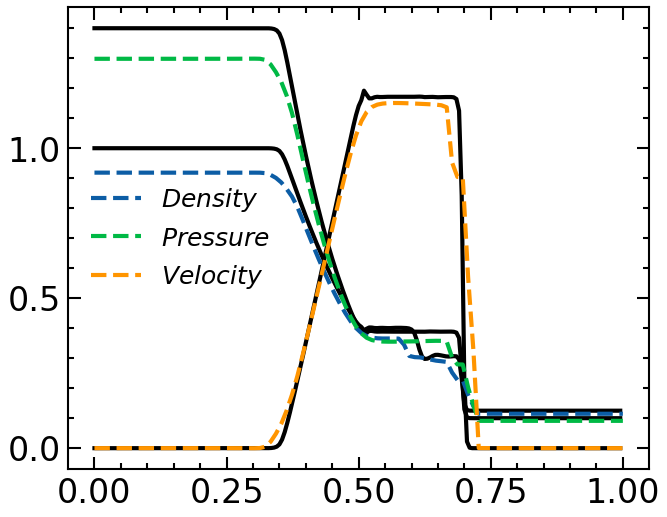

Step 2 Training Begin...
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.0220, -2.3655],
        [ 0.0252, -2.0427]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0322e+00,  8.9322e-04],
        [-4.1930e-02,  1.0001e+00]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[0.3051, 0.7056, 0.0043]], device='cuda:0', dtype=torch.float64),tensor([[0.5257, 0.5596, 0.0073]], device='cuda:0', dtype=torch.float64),tensor([[0.4152, 0.5863, 0.0257]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.205066


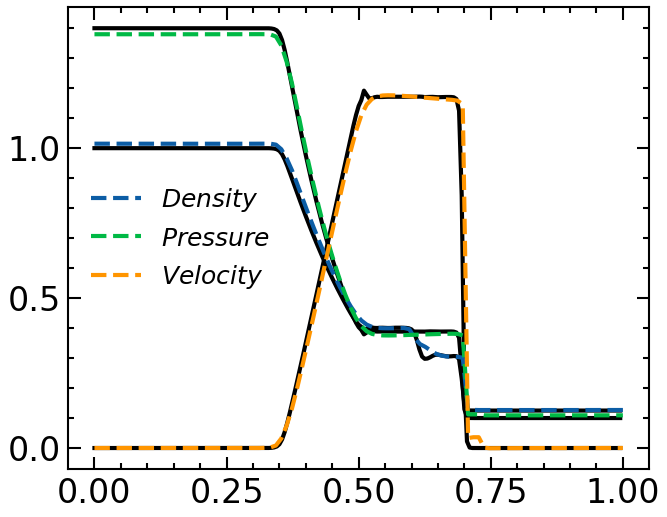

[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.0099,  0.0318],
        [-0.0008, -0.1382]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0376, -0.0013],
        [-0.0716,  1.0025]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[1.2841e-02, 9.8010e-01, 7.9561e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[ 1.8099e-02,  9.2294e-01, -4.9248e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[ 0.0250,  0.9494, -0.0020]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.029069


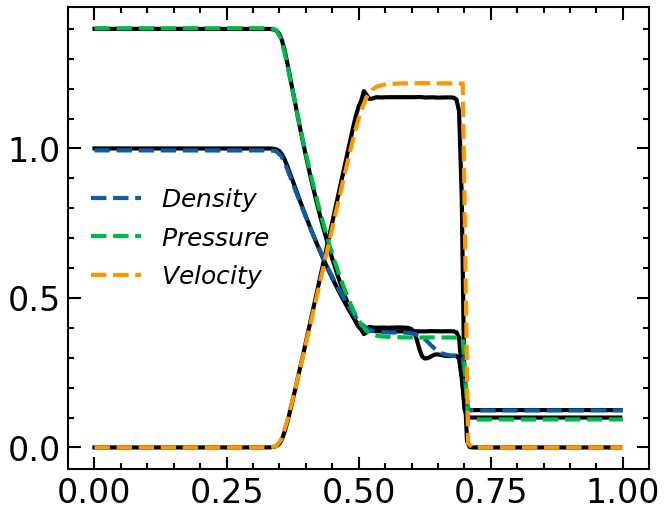

[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0440, -0.0019],
        [-0.0602,  0.9992]], device='cuda:0', dtype=torch.float64) and tensor([[0.9136, 0.0161, 0.0637]], device='cuda:0', dtype=torch.float64),tensor([[ 0.0455,  0.8952, -0.0098]], device='cuda:0', dtype=torch.float64),tensor([[0.2368, 0.7261, 0.0261]], device='cuda:0', dtype=torch.float64)
[1.0, 1.4, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.568791 (TGPT_PINN2 Step Criteria Met
)


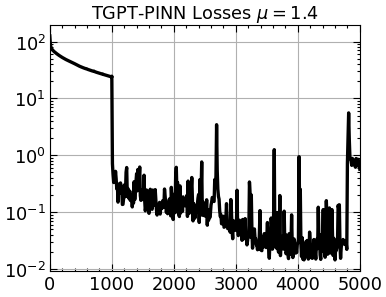

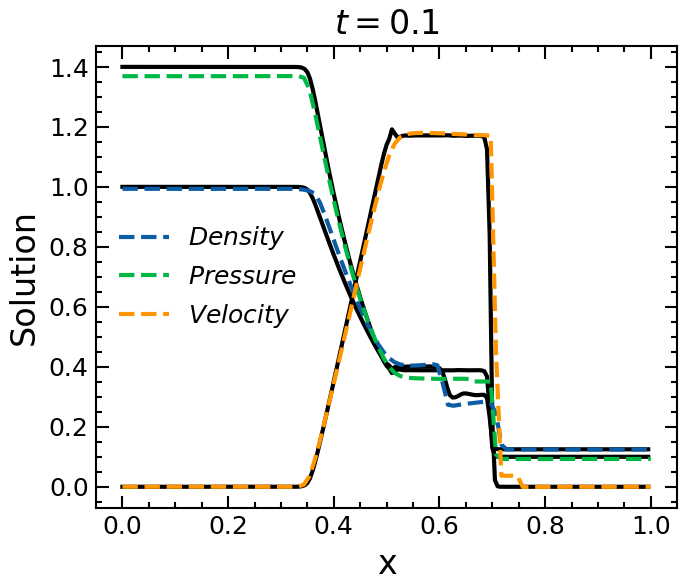

[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]: Loss: 125.599478
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.59947828611573
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 35.979945
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 23.850632
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0044e+00, -1.7779e-04],
        [-6.8184e-03,  1.0020e+00]], device='cuda:0', dtype=torch.float64) and tensor([[0.4009, 0.2672, 0.2507]], device='cuda:0', dtype=torch.float64),tensor([[0.4010, 0.2592, 0.2543]], device='cuda:0', dtype=torch.float64),tensor([[0.2572, 0.2641, 0.3991]], device='cuda:0', dtype=torch.float64)
Loss: 23.850632 (TGPT_PINN1 Step Criteria Met
)


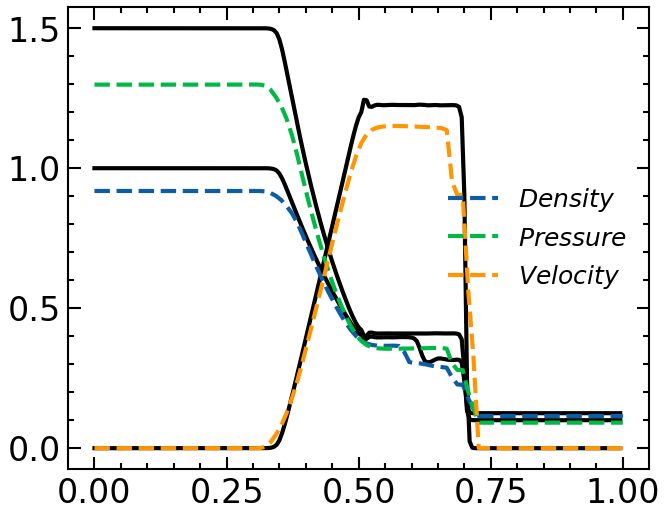

Step 2 Training Begin...
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.0039,  1.0143],
        [-0.0213,  0.6429]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0092,  0.0039],
        [-0.0231,  1.0018]], device='cuda:0', dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[0.1579, 0.8486, 0.0211]], device='cuda:0', dtype=torch.float64),tensor([[0.3876, 0.7225, 0.0016]], device='cuda:0', dtype=torch.float64),tensor([[0.3347, 0.6879, 0.0171]], device='cuda:0', dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.139522


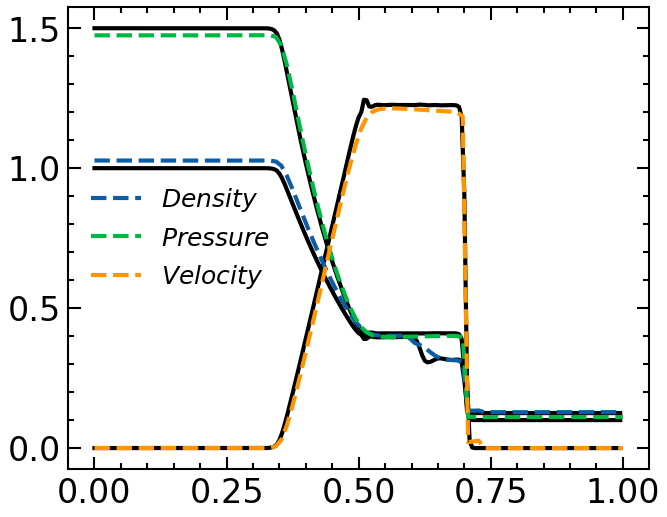

[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.0241, -0.2019],
        [ 0.0136,  0.1418]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0199,  0.0051],
        [-0.0518,  1.0033]], device='cuda:0', dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[0.0082, 0.9912, 0.0038]], device='cuda:0', dtype=torch.float64),tensor([[ 0.0474,  0.9622, -0.0020]], device='cuda:0', dtype=torch.float64),tensor([[0.0558, 0.9517, 0.0059]], device='cuda:0', dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.064893


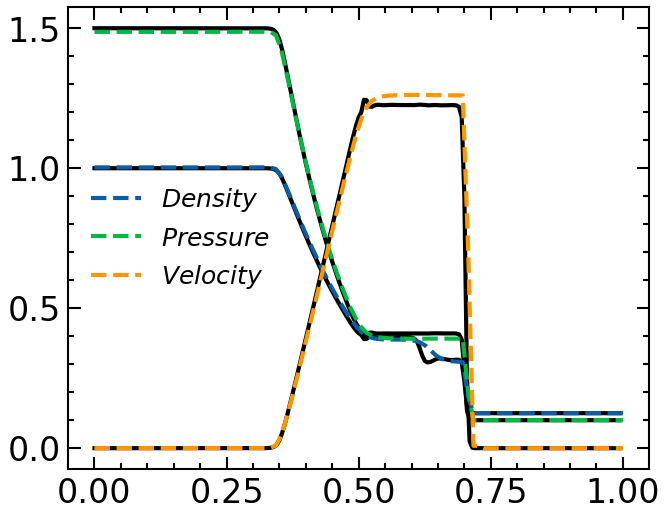

[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0395,  0.0059],
        [-0.0550,  1.0000]], device='cuda:0', dtype=torch.float64) and tensor([[ 0.0171,  0.9863, -0.0010]], device='cuda:0', dtype=torch.float64),tensor([[ 4.1260e-02,  9.7024e-01, -5.3343e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[4.4325e-02, 9.6008e-01, 4.0721e-04]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.5, 0.0, 0.125, 0.1, 0.0]:Epoch: 4869 | Loss: 0.009929 (TGPT_PINN2 Step Criteria Met
)


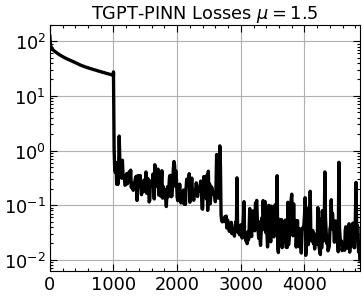

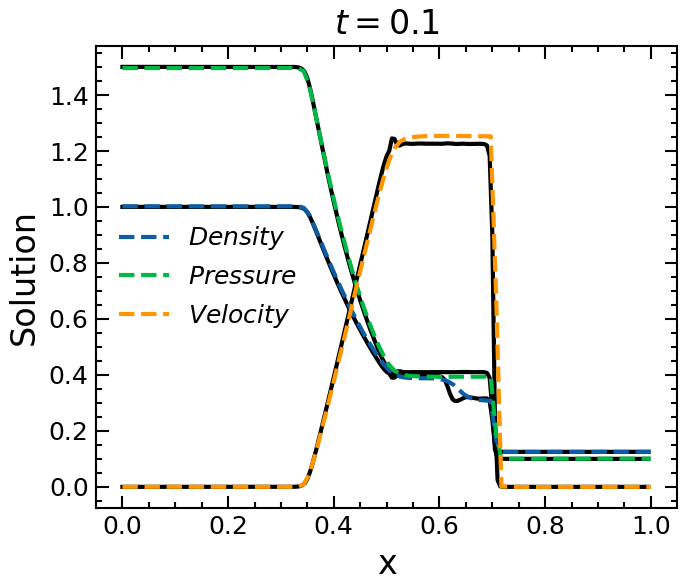

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: Loss: 125.604470
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.60446980886341
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 35.996800
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 23.955925
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0044e+00, -1.7803e-04],
        [-6.8228e-03,  1.0020e+00]], device='cuda:0', dtype=torch.float64) and tensor([[0.4010, 0.2673, 0.2507]], device='cuda:0', dtype=torch.float64),tensor([[0.4012, 0.2593, 0.2543]], device='cuda:0', dtype=torch.float64),tensor([[0.2572, 0.2641, 0.3991]], device='cuda:0', dtype=torch.float64)
Loss: 23.955925 (TGPT_PINN1 Step Criteria Met
)


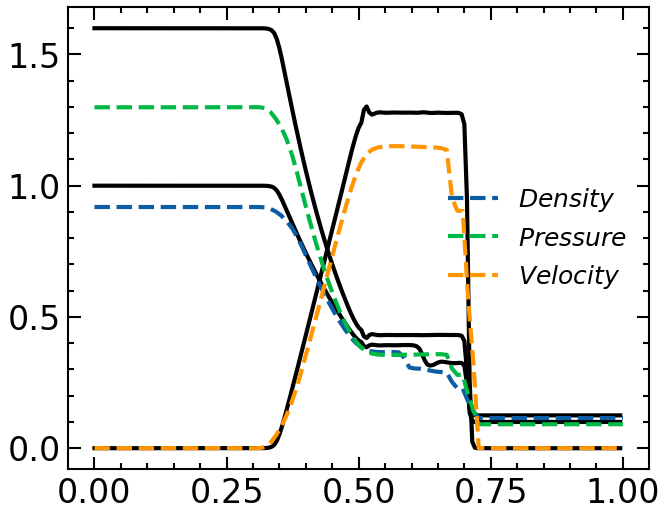

Step 2 Training Begin...
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.0833,  0.8160],
        [-0.0433, -0.5200]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0105,  0.0028],
        [-0.0294,  0.9976]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[-8.0681e-03,  1.0311e+00,  6.4384e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[1.7925e-02, 1.0418e+00, 3.6479e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[0.0127, 0.9535, 0.0403]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.170862


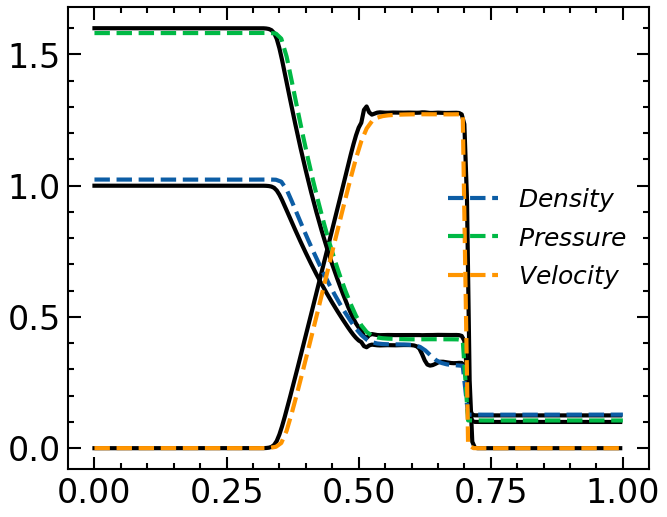

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 18.8529, 125.0099],
        [ -9.9403, -84.0678]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0477, -0.0138],
        [ 0.0253,  0.9960]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0260,  0.0753, -0.0023]], device='cuda:0', dtype=torch.float64),tensor([[ 1.4471e+00,  4.2210e-02, -1.8038e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[ 1.0389,  0.1264, -0.0195]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.839932


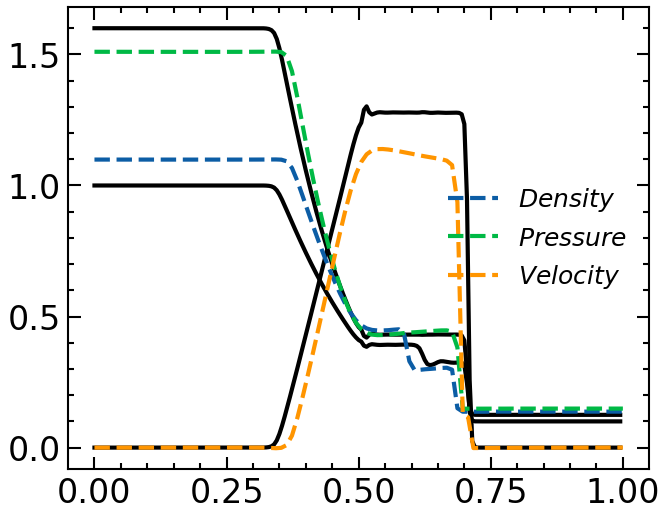

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0634, -0.0168],
        [ 0.0255,  0.9948]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0283,  0.0888, -0.0228]], device='cuda:0', dtype=torch.float64),tensor([[1.4623, 0.0462, 0.0031]], device='cuda:0', dtype=torch.float64),tensor([[ 1.0581,  0.1147, -0.0156]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 5000 | Loss: 0.697711 (TGPT_PINN2 Step Criteria Met
)


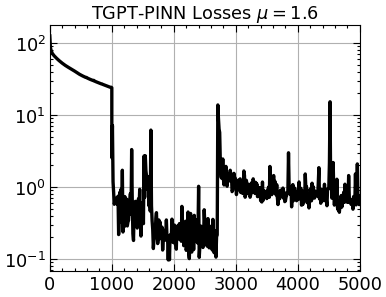

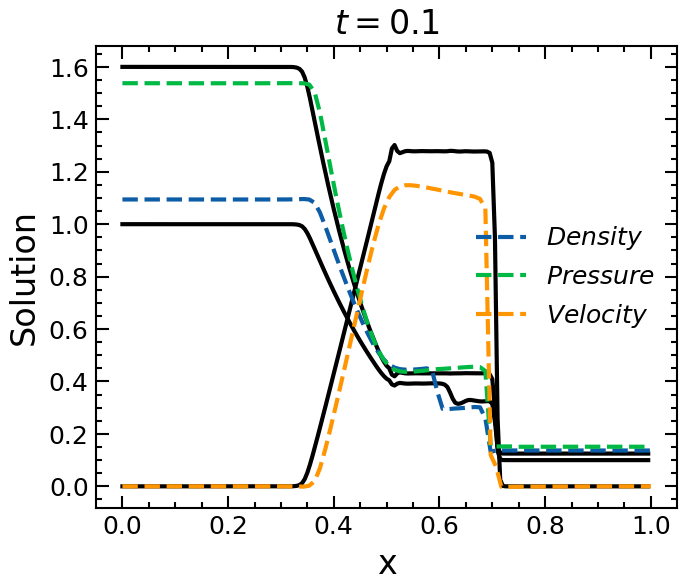

[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64),tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0', dtype=torch.float64)
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]: Loss: 125.619461
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 125.61946133161109
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 36.023646
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 23.924032
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0044e+00, -1.7827e-04],
        [-6.8269e-03,  1.0020e+00]], device='cuda:0', dtype=torch.float64) and tensor([[0.4011, 0.2673, 0.2507]], device='cuda:0', dtype=torch.float64),tensor([[0.4014, 0.2594, 0.2543]], device='cuda:0', dtype=torch.float64),tensor([[0.2572, 0.2641, 0.3991]], dev

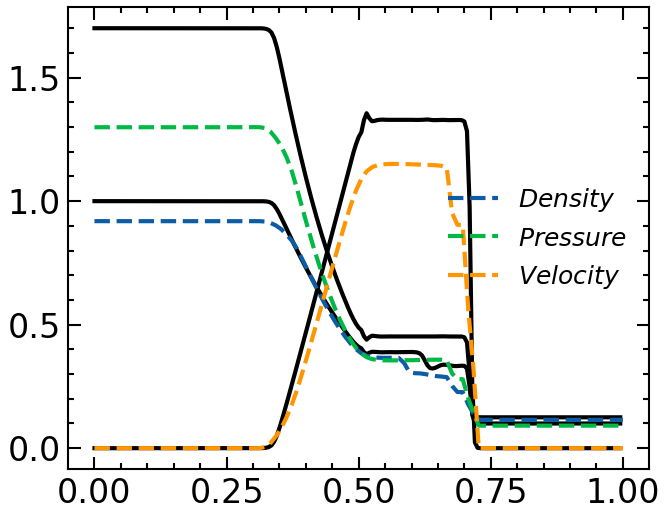

Step 2 Training Begin...
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.0418, -3.4916],
        [-0.0058, -3.7749]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0124e+00,  5.2846e-05],
        [-5.5197e-03,  9.9667e-01]], device='cuda:0', dtype=torch.float64)
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:tensor([[0.0297, 0.8876, 0.1203]], device='cuda:0', dtype=torch.float64),tensor([[0.2987, 0.7851, 0.0967]], device='cuda:0', dtype=torch.float64),tensor([[0.1860, 0.7512, 0.1018]], device='cuda:0', dtype=torch.float64)
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 0.376246


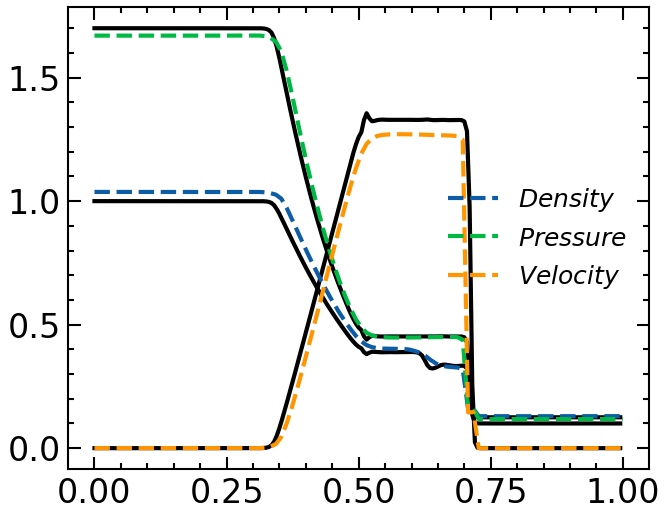

[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.0302, -0.3137],
        [ 0.0176,  0.1515]], device='cuda:0', dtype=torch.float64) and tensor([[1.0425, 0.0053],
        [0.0060, 0.9991]], device='cuda:0', dtype=torch.float64)
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.0048,  1.0149, -0.0018]], device='cuda:0', dtype=torch.float64),tensor([[ 4.5078e-02,  1.0949e+00, -4.0224e-04]], device='cuda:0',
       dtype=torch.float64),tensor([[ 0.0429,  1.0195, -0.0033]], device='cuda:0', dtype=torch.float64)
[1.0, 1.7000000000000002, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.054290


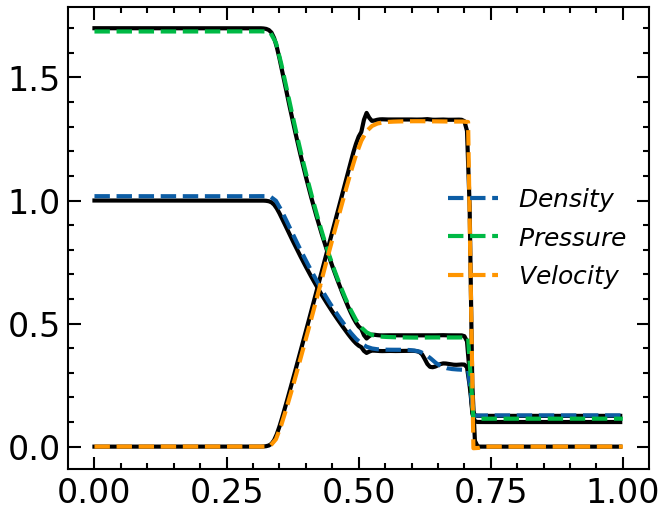

In [ ]:
i=2
layers_gpt = np.array([2, i+1, 3])
c_initial  = torch.full((1,i+1), 1/(i+1))

for nu in nu_training:
    ini[1] = nu
    IC_data = create_IC_data(ini,Xi, Xf, Ti, Tf, IC_pts)
    IC_xt     = IC_data[0].to(device)
    IC_u      = IC_data[1]

    BC_data = create_BC_data(ini,Xi, Xf, Ti, Tf, IC_pts)
    BC_xt     = BC_data[0].to(device)
    BC_u      = BC_data[1]
    xt_en = Move_Time_1D(IC_xt, Tf).to(device)
    weno_u = Euler_WENO(Xi,Xf,Ti,Tf,ini,gamma,delta_t=0.0001,delta_x=0.005)
    TGPT_PINN = GPTs(ini, layers_gpt, P_list[0:i+1], c_initial, Nc, Tc, gamma,Tf).to(device).double()
    
    tgpt_losses = gpt_train(TGPT_PINN, ini, xt_resid,  IC_xt, IC_u,BC_xt,BC_u, f_hat,xt_test,xt_en, xt_RH, xt_RHL,weno_u,  epochs_tgpt, lr_tgpt, tol_tgpt)
    
    loss_plot(tgpt_losses[1], tgpt_losses[2], dpi=80, figsize=(5,4),title=fr"TGPT-PINN Losses $\mu={round(ini[1],3)}$")
    
    Nx_test=N_test
    Nt_test=T_test
    plt.figure(dpi=150, figsize=(5,4))
    
    ind = 100
    plt.plot(weno_u[3],weno_u[0],'k')#,label="$Density$"
    plt.plot(weno_u[3],weno_u[1],'k')#,label="$Pressure$"
    plt.plot(weno_u[3],weno_u[2],'k')#,label="$velocity$"
    
    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,0:1][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Density$")
    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,1:2][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Pressure$")
    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,2:][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Velocity$")
    
    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),TGPT_PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),TGPT_PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),TGPT_PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
    plt.xlabel("x",     fontsize=16)
    plt.ylabel("Solution", fontsize=16)
    plt.title(fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    
    plt.legend(fontsize = 12)#
    plt.show()